In [1]:
# %%
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import sys
import os

# Set project root
file_path = os.getcwd()
project_root =  os.path.dirname(file_path)
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project-specific modules
from Instant_AIV.models.NNpp import *
from Instant_AIV.models.metrics import *
from Instant_AIV.manage.plots import *
from Instant_AIV.manage.dataloader import *

# Libraries
import argparse
import numpy as np
import scipy.io
import time
import gc
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator, LogLocator, FormatStrFormatter

# JAX and Optimization
import jax
from jax import jit, grad, vmap, value_and_grad, jvp
from jax.config import config
import jax.numpy as jnp
import optax

# Miscellaneous
from typing import Tuple, List, Dict
import h5py
from pyDOE import lhs
import tqdm
import scipy.integrate as integrate
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance


print(project_root)


/users/jdtoscan/Documents/Papers/Instant-AIVT
/users/jdtoscan/Documents/Papers/Instant-AIVT


In [3]:

# %%
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


## Tunning Parameters

In [4]:
parser = argparse.ArgumentParser(description='Tunning_parameters')
parser.add_argument('--run_type'   , type=str  , default='Rayleigh_Bernard')
parser.add_argument('--Name' , type=str  , default='RBC_')
parser.add_argument('--mode'       , type=str  , default='PINN')
parser.add_argument('--Run_MODE'   , type=str  , default='Train')

parser.add_argument('--num_layer'  , type=int  , default=7)
parser.add_argument('--width_layer', type=int  , default=64)
parser.add_argument('--lr0', type=float  , default=0.0003)
parser.add_argument('--lrf', type=float  , default=0.00001)


parser.add_argument('--time_start' , type=int  , default=10)
parser.add_argument('--time_final' , type=int  , default=30)
parser.add_argument('--train_ratio' , type=float, default=0.5)

parser.add_argument('--batch_size' , type=int  , default=5000)
parser.add_argument('--num_gsteps' , type=int  , default=300*(10**3))
parser.add_argument('--Equal_Batch' , type=bool  , default=True)
parser.add_argument('--optimzer' , type=str  , default='AdamW')
#RBA-R
parser.add_argument('--use_RBA'    , type=bool , default=True)
parser.add_argument('--k_samp' , type=float  , default=2.0)
parser.add_argument('--c_samp' , type=float  , default=0.5)
parser.add_argument('--lr_lambdas_0' , type=float  , default=0.1)
parser.add_argument('--gamma' , type=float  , default=0.999)
#Sequential
parser.add_argument('--Seq_train'    , type=bool , default=True)
#VP-VV
parser.add_argument('--Eqn'    , type=str , default='VV')

#KAN Params
parser.add_argument('--Network_type' , type=str , default='KAN')
parser.add_argument('--degree' , type=int , default=5)

args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

run_type: Rayleigh_Bernard
Name: RBC_
mode: PINN
Run_MODE: Train
num_layer: 7
width_layer: 64
lr0: 0.0003
lrf: 1e-05
time_start: 10
time_final: 30
train_ratio: 0.5
batch_size: 5000
num_gsteps: 300000
Equal_Batch: True
optimzer: AdamW
use_RBA: True
k_samp: 2.0
c_samp: 0.5
lr_lambdas_0: 0.1
gamma: 0.999
Seq_train: True
Eqn: VV
Network_type: KAN
degree: 5


In [5]:
Run_type = args.run_type
Mode=args.mode
num_layer=args.num_layer
width_layer=args.width_layer
layers={
    "uvwT" :[4] + num_layer*[width_layer] + [4],
}
layers_1=np.copy(layers["uvwT"])

time_start=args.time_start
time_final=args.time_final
train_ratio=args.train_ratio
args.k_samp=args.k_samp*args.use_RBA  
use_RBA=args.use_RBA


Run_MODE=args.Run_MODE

print('Model Architecture:')
print(layers)

activation = 'tanh'
initialization = 'xavier'
normalization  = 'plusminus1'
loss_metric ='L2'
init_zero=True

seed_np=1234

Details=f'{args.Name}_{args.Network_type}_Eqn:{args.Eqn}_RBA-R:{args.use_RBA}-Seq:{args.Seq_train}'

#Optimization
num_gsteps  = args.num_gsteps
batch_size = args.batch_size

#learning 
lam_min=0.0
lr0=args.lr0 
lrf=args.lrf
lr_lambdas_0=args.lr_lambdas_0
gamma=args.gamma
max_lambda=lr_lambdas_0/(1-gamma)
print(f'Max lambdas will be:{max_lambda}')
T_e=num_gsteps
decay_rate=0.9
decay_step=0
seed_np=1234
key = jax.random.PRNGKey(seed_np)
key, subkey = jax.random.split(key)
#Model
Re=1
nu_v=1/Re
Raf=3.4*10**(7)
Pr=10.4

#Sample Points
N_b = int(5e4)
N_u = int(5e5)
N_r = int(8e5) 

#Scales
u_scale=1
v_scale=1
w_scale=1
p_scale=1
T_scale=0.1
#SNR


dataset_name = f'{Details}_RBA:{use_RBA}'

data_path=project_root+"/Data/Rayleigh-Benard-Convection/Data_txyzuvwT.mat"
save_path=project_root+f'/Results/{Run_type}/'
print(f'Analizing:{data_path}')
print(f'Details:{Details}')

Model Architecture:
{'uvwT': [4, 64, 64, 64, 64, 64, 64, 64, 4]}
Max lambdas will be:99.99999999999991
Analizing:/users/jdtoscan/Documents/Papers/Instant-AIVT/Data/Rayleigh-Benard-Convection/Data_txyzuvwT.mat
Details:RBC__KAN_Eqn:VV_RBA-R:True-Seq:True


## Settings

In [6]:

# Fetching activation function
activation_fn = ACTIVATION_FUNCTIONS.get(activation.lower())

# Fetching normalization functions and metrics
norm_settings = NORMALIZATION_FUNCTIONS.get(normalization.lower())
norm_fn = norm_settings['fn']
Norm_metric1 = norm_settings['metric1']
Norm_metric2 = norm_settings['metric2']

# Fetching error function
Error_fn = ERROR_FUNCTIONS.get(loss_metric.lower())

if normalization.lower()=='fourier_time':
    embed_size=layers['uvwT'][1]
    input_dim=layers['uvwT'][0]-1
    output_dim=layers['uvwT'][-1]
    layers["uvwT"]=(num_layer)*[(2*input_dim)*(embed_size//(2*input_dim))+input_dim+1]+ [output_dim]
    print(f'New architecture:{layers}')


# %%
# %%
np.random.seed(seed_np)
params_NN = init_params_dict(layer_dict=layers,
                             initialization= initialization,
                             Network_type=args.Network_type,
                             degree=args.degree)
alpha=0.1
beta=5.0
params=(alpha,beta,params_NN)

# Model selection
pinn_fn =select_model( 
                      Network_type=args.Network_type,
                      degree=args.degree)
print(f'The model will be: {pinn_fn}')

# Optimizer Initialization
optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, T_e,optimizer_type=args.optimzer)
opt_state = optimizer.init(params)


# %%
M1= Norm_metric1
M2= Norm_metric2
print('Norm metrics:',M1,M2)



You selected: Network KAN with degree(if KAN) 5, initialization xavier
Initializing:KAN parameters.
The model will be: <function KAN_Net5 at 0x7f3a5a11f940>
Optimizer adamw
Weight decay: 1e-05
The decay step will be 9293.243275960971
Norm metrics: <function <lambda> at 0x7f3a5d6f2940> <function <lambda> at 0x7f3a5d6f29d0>


## Create Folders

In [7]:

# %%
subdirs = ["General","Imgs", "Big_Data", "Data", "Flow_rate", "Errors","All_times"]
paths = create_and_return_directories(save_path, dataset_name, subdirs)
result_path = paths["General"]
images_path = paths["Imgs"]
big_path = paths["Big_Data"]
flowrate_path = paths["Flow_rate"]
All_path = paths["All_times"]
errors_path = paths["Errors"]

The general path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/General/
The imgs path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/Imgs/
The big data path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/Big_Data/
The data path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/Data/
The flow rate path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/Flow_rate/
The errors path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RBA:True/Errors/
The all times path is: /users/jdtoscan/Documents/Papers/Instant-AIVT/Results/Rayleigh_Bernard/RBC__KAN_Eqn:VV_RBA-R:True-Seq:True_RB

## Load Data

In [8]:
Loaded_data=scipy.io.loadmat(data_path)
X_star_f= Loaded_data['txyz']
u_star_f = Loaded_data['uvwT']

## BCs

In [9]:
X_final=np.hstack([X_star_f,u_star_f])

lb, ub = np.min(X_star_f, axis=0), np.max(X_star_f, axis=0)
x_min, y_min = lb[0], lb[1]
x_max, y_max = ub[0], ub[1]
print(lb)
print(ub)
print(X_star_f.shape,u_star_f.shape)


# Given ranges for x, y, and z
t_list = np.linspace(lb[0], ub[0], 200).flatten()[:, None]
x_list = np.linspace(lb[1], ub[1], 100).flatten()[:, None]
y_list = np.linspace(0, 1, 100).flatten()[:, None]
z_list = np.linspace(lb[3], ub[3], 40).flatten()[:, None]

# Create 3D mesh
X_mesh, Y_mesh, Z_mesh = np.meshgrid(x_list.flatten(), y_list.flatten(), z_list.flatten(), indexing='ij')

# Printing shapes for verification
print(f"X_mesh shape: {X_mesh.shape}")
print(f"Y_mesh shape: {Y_mesh.shape}")
print(f"Z_mesh shape: {Z_mesh.shape}")
X_eval=np.hstack((X_mesh.flatten()[:, None],
                  Y_mesh.flatten()[:, None],
                  Z_mesh.flatten()[:, None],))

print(f"X_eval shape: {X_eval.shape}")



[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586309  0.63559492  0.99108983  0.10093542]
(840816, 4) (840816, 4)
X_mesh shape: (100, 100, 40)
Y_mesh shape: (100, 100, 40)
Z_mesh shape: (100, 100, 40)
X_eval shape: (400000, 3)


### Extract Bcs

In [10]:
t_list = np.linspace(lb[0], ub[0], 200).flatten()[:, None]
# Create boolean masks for the condition
mask_0 = X_eval[:, 1] == 0
mask_1 = X_eval[:, 1] == 1
# Split the data
X_bottom = X_eval[X_eval[:, 1] == 0]
X_top = X_eval[X_eval[:, 1] == 1]
X_BCs_T=[]
X_BCs_B=[]

for t_frame in tqdm.tqdm(t_list):
    X_BCs_T.append(np.hstack((X_top[:,0:1]*0+t_frame,X_top)))
    X_BCs_B.append(np.hstack((X_bottom[:,0:1]*0+t_frame,X_bottom)))
X_BCs_T=np.concatenate(X_BCs_T)
X_BCs_B=np.concatenate(X_BCs_B)
print(X_BCs_T.shape,X_BCs_B.shape)


100%|██████████| 200/200 [00:00<00:00, 6954.98it/s]

(800000, 4) (800000, 4)


# Residual Points


In [11]:
print(lb)
print(ub)
X_r = lb + (ub-lb)*lhs(4,6* N_r//8)
print(X_r.shape)

ub1=[ub[0],ub[1],ub[2]/10,ub[3]]
lb1=np.copy(lb)
print(lb1)
print(ub1)
X_r1 = lb1 + (ub1-lb1)*lhs(4, 1* N_r//8)
print(X_r1.shape)

ub2=np.copy(ub)
lb2=[lb[0],lb[1],9*ub[2]/10,lb[3]]
print(lb2)
print(ub2)

X_r2 = lb2 + (ub2-lb2)*lhs(4, 1* N_r//8)
print(X_r2.shape)




[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586309  0.63559492  0.99108983  0.10093542]
(600000, 4)
[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586308582471, 0.6355949152542374, 0.09910898305084745, 0.10093542372881356]
(100000, 4)
[10.015464842793197, -0.615306779661017, 0.8919808474576272, -0.10071864406779661]
[29.97586309  0.63559492  0.99108983  0.10093542]
(100000, 4)


### Group Dataset

In [12]:
X_res=np.vstack([X_r,X_r1,X_r2])
X_sol=np.hstack((X_star_f,u_star_f))
print(X_sol.shape)
unique_times=np.unique(X_sol[:,0:1])
frames = []  # List to store frames
# Loop over each unique time
for time_frame in tqdm.tqdm(unique_times):
    # Filter X_sol for the current time
    frame = X_sol[X_sol[:, 0] == time_frame]
    # Append the frame to the list
    frames.append(frame)


# %%
if train_ratio<=0.5:
    skip_frames = int(1 / train_ratio)
    idx_all_frames = np.arange(0, len(frames))
    idx_Train = np.arange(1, len(frames) - 1, skip_frames)
    idx_Train = np.append([0], idx_Train)  # Add the first frame
    idx_Train = np.append(idx_Train, [len(frames) - 1])  # Add the last frame
    idx_Test = np.setdiff1d(idx_all_frames, idx_Train)
    print(f'Skipping:{skip_frames}')
    print(f'Training on frames:{idx_Train}')
    print(f'Testing on frames:{idx_Test}')
    print(f'Training on {len(idx_Train)/len(frames)}')
else:
    idx_all_frames =np.arange(0,len(frames))
    np.random.seed(seed_np)
    idx_Train=np.random.choice(len(frames),int(len(frames)*train_ratio),replace=False)
    idx_Train = np.append([0], idx_Train)  # Add the first frame
    idx_Train = np.append(idx_Train, [len(frames) - 1])  # Add the last frame
    idx_Train = np.unique(idx_Train)
    idx_Test =np.setdiff1d(idx_all_frames,idx_Train)
    print(f'There are not enough frames to skip')
    print(f'Training on frames:{np.sort(idx_Train)}')
    print(f'Testing on frames:{idx_Test}')

# %%
X_train=np.zeros((1,X_sol.shape[1]))
for idx in tqdm.tqdm(idx_Train):
    X_train=np.vstack((X_train,frames[idx]))
X_train=X_train[1:]
X_test=np.zeros((1,X_sol.shape[1]))
for idx in tqdm.tqdm(idx_Test):
    X_test=np.vstack((X_test,frames[idx]))
X_test=X_test[1:]

# %%
#
num_points=150000
if len(X_test)<num_points:
    X_GT=np.copy(X_test)
else:
    np.random.seed(seed_np)   
    idx_Gt=np.random.choice(len(X_test),num_points,replace=False)
    X_GT=X_test[idx_Gt]

#Subsample BCs
np.random.seed(seed_np)
idx_bc_T=np.random.choice(len(X_BCs_T),N_b,replace=False)
np.random.seed(seed_np)
idx_bcs_B=np.random.choice(len(X_BCs_B),N_b,replace=False)
X_Top=X_BCs_T[idx_bc_T]
X_Bot=X_BCs_B[idx_bcs_B]

# Printing the shapes of the datasets for verification
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test Eval set shape: {X_GT.shape}")
print(f"BCs Top shape: {X_Top.shape}")
print(f"Bcs Bottom set shape: {X_BCs_B.shape}")


(840816, 8)


100%|██████████| 284/284 [00:00<00:00, 422.10it/s]


Skipping:2
Training on frames:[  0   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33
  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69
  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105
 107 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141
 143 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177
 179 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213
 215 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249
 251 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283]
Testing on frames:[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 1

100%|██████████| 141/141 [00:00<00:00, 903.09it/s] 


Training set shape: (423546, 8)
Test set shape: (417270, 8)
Test Eval set shape: (150000, 8)
BCs Top shape: (50000, 4)
Bcs Bottom set shape: (800000, 4)


# Select Tempertature

In [13]:
X_train_T=X_train
X_train_T=filter_Magnitude(X_train_T,row=2,T_max=0.9,T_min=0.1)

# Balance data
X_train=filter_Magnitude(X_train,row=2,T_max=0.9,T_min=0.1)
X_test=filter_Magnitude(X_test,row=2,T_max=0.9,T_min=0.1)
X_GT=filter_Magnitude(X_GT,row=2,T_max=0.9,T_min=0.1)
# Oversample Residuals
lb_res=X_res.min(0)
ub_res=X_res.max(0)
print(lb_res)
print(ub_res)
N_r=100000
X_res2 = lb + (ub-lb)*lhs(4, N_r)
X_res_low=filter_Magnitude(X_res2,row=2,T_max=0.1,T_min=0.0)
X_res_high=filter_Magnitude(X_res2,row=2,T_max=1.0,T_min=0.9)
print('Low res region',X_res_low.shape)
print(X_res_low.min(0))
print(X_res_low.max(0))
print('High res region',X_res_high.shape)
print(X_res_high.min(0))
print(X_res_high.max(0))
X_res=np.vstack((X_res,X_res_low,X_res_high))
print('All res region',X_res.shape)
print(X_res.min(0))
print(X_res.max(0))

# %% [markdown]

[10.01546646 -0.61530506  0.01921565 -0.10071861]
[29.97584736  0.63559487  0.99108959  0.10093516]
Low res region (8313, 4)
[10.01822279 -0.61502465  0.01922066 -0.10068734]
[29.9742856   0.63556844  0.09999887  0.10093431]
High res region (9373, 4)
[10.0159289  -0.61529567  0.90000477 -0.10069977]
[29.97471924  0.63557695  0.99108969  0.10086142]
All res region (817686, 4)
[10.01546646 -0.61530506  0.01921565 -0.10071861]
[29.97584736  0.63559487  0.99108969  0.10093516]


## Data Analytics

In [14]:
# %%
print(f'Bounds for Data Train with {X_train.shape} points:')
print(np.min(X_train,axis=0))
print(np.max(X_train,axis=0))
print(f'Bounds for Data Train T with {X_train_T.shape} points:')
print(np.min(X_train_T,axis=0))
print(np.max(X_train_T,axis=0))
print(f'Bounds for Data Test with {X_test.shape} points:')
print(np.min(X_test,axis=0))
print(np.max(X_test,axis=0))
print(f'Bounds for Data Eval with {X_GT.shape} points:')
print(np.min(X_GT,axis=0))
print(np.max(X_GT,axis=0))  
print(f'Bounds for Residual Data with {X_res.shape} points:')
print(np.min(X_res,axis=0))
print(np.max(X_res,axis=0))
print(f'Bounds for Top BCs Data with {X_Top.shape} points:')
print(np.min(X_Top,axis=0))
print(np.max(X_Top,axis=0))
print(f'Bounds for Bottom BCs Data with {X_Bot.shape} points:')
print(np.min(X_Bot,axis=0))
print(np.max(X_Bot,axis=0))

# %%
dataset = {
    'Data': X_train,
    'Data_T': X_train_T,
    'Bcs_T': X_Top,
    'Bcs_B': X_Bot,
    'Test': X_test,
    'Res': X_res,
    'GT': X_GT
}
lam = {
    'Data': 1000,
    'Data_T': 10,
    'Bcs_T': 10,
    'Bcs_B': 10,
    'Test': 1,
    'Res': 1,
    'GT': 1,
    'Mx': 1e-10,
    'My': 1e-10,
    'Mz':1e-10,
    'Mass':1,
    'MT':1e-10,
}
neq = {
    'Data': 3,
    'Data_T': 1,
    'Bcs_T': 4,
    'Bcs_B': 4,
    'Test': 1,
    'Res': 8,
    'GT': 1
}



Bounds for Data Train with (381955, 8) points:
[10.01546484 -0.61530678  0.10000508 -0.10068661 -0.15066165 -0.10709266
 -0.11128795  0.44038885]
[29.97586309  0.63559492  0.89999492  0.10037068  0.14506438  0.13526639
  0.11564086  0.71995009]
Bounds for Data Train T with (381955, 8) points:
[10.01546484 -0.61530678  0.10000508 -0.10068661 -0.15066165 -0.10709266
 -0.11128795  0.44038885]
[29.97586309  0.63559492  0.89999492  0.10037068  0.14506438  0.13526639
  0.11564086  0.71995009]
Bounds for Data Test with (376519, 8) points:
[10.15652773 -0.61414915  0.10000339 -0.10071864 -0.15140789 -0.10668008
 -0.10878694  0.44038478]
[29.90533164  0.63332203  0.89999831  0.10084373  0.14794536  0.13455819
  0.11220858  0.71820317]
Bounds for Data Eval with (135140, 8) points:
[10.15652773 -0.61314746  0.10000678 -0.09947576 -0.15140789 -0.10668008
 -0.10792397  0.44263252]
[29.90533164  0.62943729  0.89998814  0.10042729  0.14208958  0.13305791
  0.10884271  0.7167673 ]
Bounds for Residual 

143


  0%|          | 0/1 [00:00<?, ?it/s]

[11.35556225 -0.60389831  0.10002034 -0.09616864 -0.10571385 -0.1011322
 -0.07807582  0.44553932]
[11.35556225  0.61491525  0.89972373  0.09444153  0.11576586  0.11777348
  0.1049988   0.65104327]


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

plot


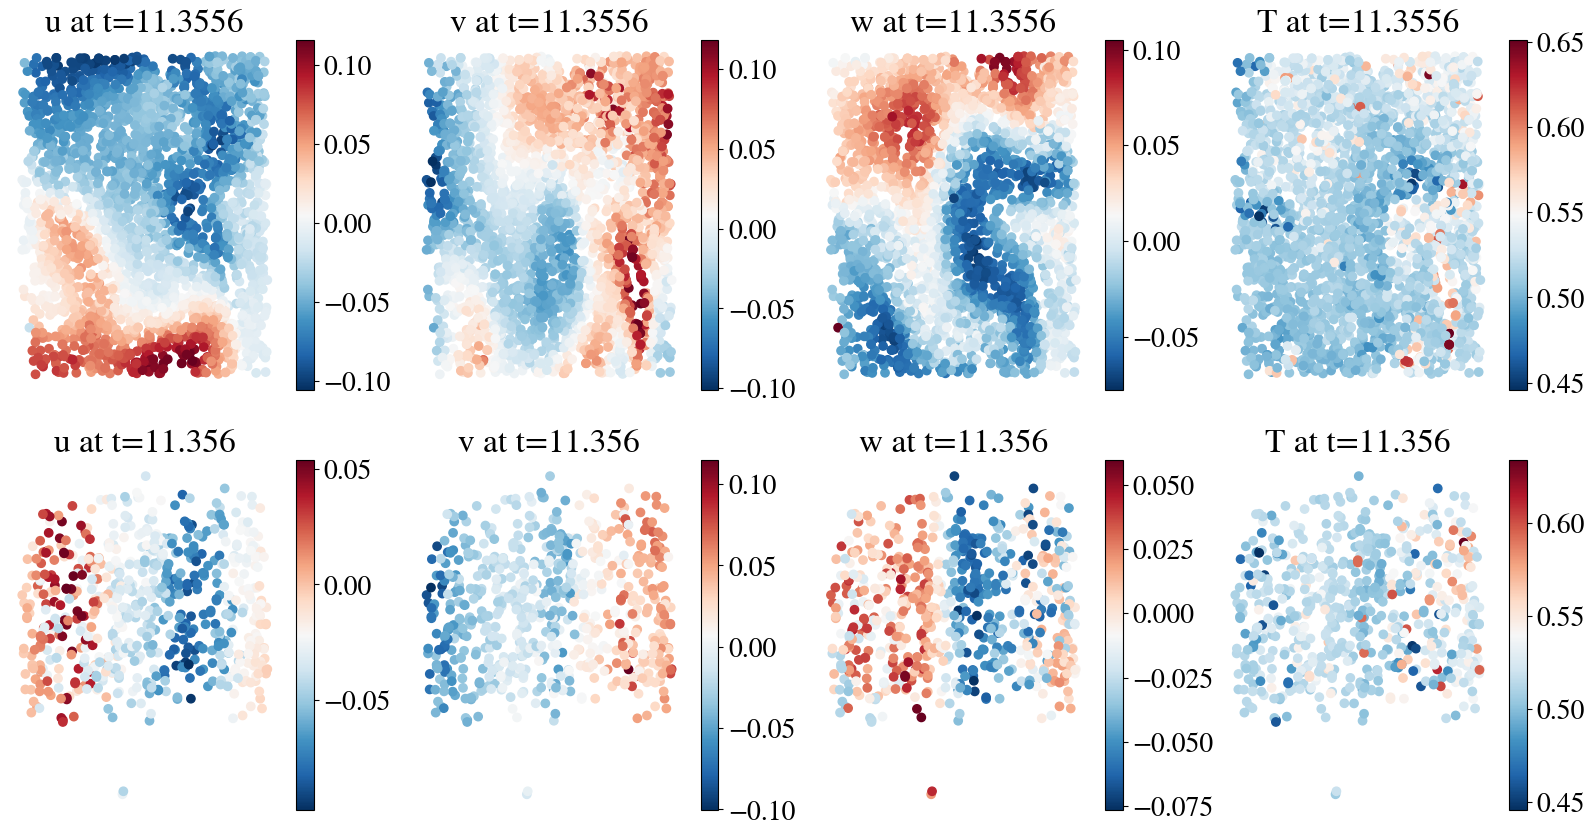

In [15]:

# %%
all_times=np.sort(np.unique(X_train[:,0]))
print(len(all_times))
start=10
end=start+1

for indx_t in tqdm.tqdm(range(start,end)):
    time_filter = X_train[:, 0] == all_times[indx_t]
    data_at_time = X_train[time_filter]
    print(data_at_time.min(0))
    print(data_at_time.max(0))


    # Extract U, V, W, and Theta for the specific time
    U = data_at_time[:, 4]
    V = data_at_time[:, 5]
    W = data_at_time[:, 6]
    Theta = data_at_time[:, 7]

    # Coordinates for plotting
    x_coord = data_at_time[:, 1]
    y_coord = data_at_time[:, 2]
    z_coord = data_at_time[:, 3]

    # Determine the midplane values for y and z
    y_midplane = np.median(y_coord)
    z_midplane = np.median(z_coord)

    # Define a small range (tolerance) for the midplane
    tolerance = 0.1  # Adjust this value as needed

    # Filtering data for y and z midplanes within the tolerance
    y_midplane_filter = np.abs(y_coord - y_midplane) <= tolerance
    z_midplane_filter = np.abs(z_coord - z_midplane) <= tolerance

    # Component names
    component_names = ['u', 'v', 'w', 'T']

    # Current time
    t = all_times[indx_t]
    name_image=result_path+f'Raw_at_t={t/len(all_times):.8f}.png'
    # Plotting
    fig = plt.figure(figsize=(20, 10))

    # Define colormap
    cmap = 'RdBu_r'

    # Plotting for midplane in z
    for i, comp in enumerate([U, V, W, Theta], start=1):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[z_midplane_filter], y_coord[z_midplane_filter], c=comp[z_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-1]} at t={t:.4f}')
        plt.axis('off')
        plt.colorbar(scatter)

    # Plotting for midplane in y
    for i, comp in enumerate([U, V, W, Theta], start=5):
        ax = fig.add_subplot(2, 4, i)
        scatter = ax.scatter(x_coord[y_midplane_filter], z_coord[y_midplane_filter], c=comp[y_midplane_filter], cmap=cmap)
        ax.set_title(f'{component_names[i-5]} at t={t:.3f}')
        plt.axis('off')
        plt.colorbar(scatter)

    plt.savefig(name_image)
    print('plot')


# %% [markdown]

 # RBA_Weights

In [16]:
# %%
lenghts=[]
for key in dataset.keys():
    lenghts.append(len(dataset[key]))
    print(f'Lenght of {key} dataset: {len(dataset[key])}')
N_train=int(np.max(lenghts))
if batch_size<0:
    batch_size=N_train
All_its=int(np.ceil(N_train/batch_size))
BATCH_SIZES = {}


for key in dataset.keys():
    if not(key == 'GT' or key == 'Test'):
        BATCH_SIZES[key] = int(np.ceil(len(dataset[key]) / All_its))
        if args.Equal_Batch:
            if len(dataset[key])>=batch_size:
                BATCH_SIZES[key]=batch_size
            else:
                BATCH_SIZES[key]=len(dataset[key])
        print(f'Batch size for {key} dataset: {BATCH_SIZES[key]}')
    

lambdas={}
for key in dataset.keys():
    np.random.seed(seed_np)
    lambdas[key] = np.random.uniform(0, 1, size=(len(dataset[key]), neq[key]))
    if init_zero:
        lambdas[key]= lambdas[key]*0+max_lambda/5
    print(f'Lambda shape for {key} dataset: {lambdas[key].shape}')


Lenght of Data dataset: 381955
Lenght of Data_T dataset: 381955
Lenght of Bcs_T dataset: 50000
Lenght of Bcs_B dataset: 50000
Lenght of Test dataset: 376519
Lenght of Res dataset: 817686
Lenght of GT dataset: 135140
Batch size for Data dataset: 5000
Batch size for Data_T dataset: 5000
Batch size for Bcs_T dataset: 5000
Batch size for Bcs_B dataset: 5000
Batch size for Res dataset: 5000
Lambda shape for Data dataset: (381955, 3)
Lambda shape for Data_T dataset: (381955, 1)
Lambda shape for Bcs_T dataset: (50000, 4)
Lambda shape for Bcs_B dataset: (50000, 4)
Lambda shape for Test dataset: (376519, 1)
Lambda shape for Res dataset: (817686, 8)
Lambda shape for GT dataset: (135140, 1)


# Loss Functions

In [17]:

# %%
scale_p=1
Ra=Raf
sqrt_Pr_over_Ra=jnp.sqrt(Pr/Ra)
sqrt_1_over_PrRa=jnp.sqrt(1/(Pr*Ra))
print('sqrt_Pr_over_Ra,Re_eq=',sqrt_Pr_over_Ra,1/sqrt_Pr_over_Ra)
print('sqrt_1_over_PrRa,Re_eq=',sqrt_1_over_PrRa,1/sqrt_1_over_PrRa)
U=0.3
um=U/2
vm=U/2
wm=U/2
Tm=0.5
beta=5
alpha=0.1
Y_max=1.0
def Rayleight_Bernard_eq(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    u_xx = lambda x: derivative_fn(u_x, x, 1)
    u_yy = lambda x: derivative_fn(u_y, x, 2)
    u_zz = lambda x: derivative_fn(u_z, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    v_xx = lambda x: derivative_fn(v_x, x, 1)
    v_yy = lambda x: derivative_fn(v_y, x, 2)
    v_zz = lambda x: derivative_fn(v_z, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)

    w_xx = lambda x: derivative_fn(w_x, x, 1)
    w_yy = lambda x: derivative_fn(w_y, x, 2)
    w_zz = lambda x: derivative_fn(w_z, x, 3)

    T_t = lambda x: derivative_fn(T, x, 0)
    T_x = lambda x: derivative_fn(T, x, 1)
    T_y = lambda x: derivative_fn(T, x, 2)
    T_z = lambda x: derivative_fn(T, x, 3)

    T_xx = lambda x: derivative_fn(T_x, x, 1)
    T_yy = lambda x: derivative_fn(T_y, x, 2)
    T_zz = lambda x: derivative_fn(T_z, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    #Vorticity in x Omega_x=a
    a_t = lambda x: derivative_fn(a, x, 0)
    a_x = lambda x: derivative_fn(a, x, 1)
    a_y = lambda x: derivative_fn(a, x, 2)
    a_z = lambda x: derivative_fn(a, x, 3)
    a_xx = lambda x: derivative_fn(a_x, x, 1)
    a_yy = lambda x: derivative_fn(a_y, x, 2)
    a_zz = lambda x: derivative_fn(a_z, x, 3)
    #Vorticity in y Omega_y=b
    b_t = lambda x: derivative_fn(b, x, 0)
    b_x = lambda x: derivative_fn(b, x, 1)
    b_y = lambda x: derivative_fn(b, x, 2)
    b_z = lambda x: derivative_fn(b, x, 3)
    b_xx = lambda x: derivative_fn(b_x, x, 1)
    b_yy = lambda x: derivative_fn(b_y, x, 2)
    b_zz = lambda x: derivative_fn(b_z, x, 3)
    #Vorticity in z Omega_z=c
    c_t = lambda x: derivative_fn(c, x, 0)
    c_x = lambda x: derivative_fn(c, x, 1)
    c_y = lambda x: derivative_fn(c, x, 2)
    c_z = lambda x: derivative_fn(c, x, 3)
    c_xx = lambda x: derivative_fn(c_x, x, 1)
    c_yy = lambda x: derivative_fn(c_y, x, 2)
    c_zz = lambda x: derivative_fn(c_z, x, 3)
    # equations
    eq1 = (
        lambda x: (
                a_t(x)+ (u(x) * a_x(x) + v(x) * a_y(x) + w(x) * a_z(x))
                -       (a(x) * u_x(x) + b(x) * u_y(x) + c(x) * u_z(x))
                -  (nu_1)* (a_xx(x) + a_yy(x)+a_zz(x))
                +  T_z(x))
                )
    eq2 = (
        lambda x: (
                b_t(x)+ (u(x) * b_x(x) + v(x) * b_y(x)+ w(x) * b_z(x))
                -       (a(x) * v_x(x) + b(x) * v_y(x)+ c(x) * v_z(x))
                -  (nu_1) * (b_xx(x) + b_yy(x)+b_zz(x))
    ))
    eq3 = (
        lambda x: (
                c_t(x)+ (u(x) * c_x(x) + v(x) * c_y(x) + w(x) * c_z(x))
                -       (a(x) * w_x(x) + b(x) * w_y(x) + c(x) * w_z(x))
                -  (nu_1)* (c_xx(x) + c_yy(x)+c_zz(x))
                -  T_x(x))
                )
    eq4 = (
        lambda x: (u_x(x)+v_y(x)+w_z(x))
                )
    eq5 = (
        lambda x: (
                 T_t(x) + (u(x) * T_x(x) + v(x) * T_y(x)+w(x)*T_z(x))
                -  (nu_2)* (T_xx(x) + T_yy(x)+ T_zz(x)))
                )
    eq6 = (
        lambda x: (c_y(x)-b_z(x)+(u_xx(x)+u_yy(x)+u_zz(x)))
                )
    eq7 = (
        lambda x: (a_z(x)-c_x(x)+(v_xx(x)+v_yy(x)+v_zz(x)))
                )
    eq8 = (
        lambda x: (b_x(x)-a_y(x)+(w_xx(x)+w_yy(x)+w_zz(x)))
                )
    return eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8


# %%
def u_PINN(params):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    Omega=lambda x: jnp.sqrt(a(x)**2+b(x)**2+c(x)**2)
    return u, v,w, b , T   
u_model=u_PINN
PDE_eq= Rayleight_Bernard_eq


sqrt_Pr_over_Ra,Re_eq= 0.0005530663 1808.1014
sqrt_1_over_PrRa,Re_eq= 5.317945e-05 18804.256


## Training

In [18]:

@jit
def update_L2(params, lambdas,lam,Ra, opt_state, dataset: Dict[str, np.ndarray], batch_indices: Dict[str, np.ndarray]):
    # Compute the predictions based on the given functions.
    def compute_prediction(X, funcs):
        result = jnp.zeros((X.shape[0], len(funcs)))
        for i, fn in enumerate(funcs):
            result = result.at[:, i].set(vmap(fn, (0))(X[:, :layers_1[0]]).flatten())
        return result
    def loss_fn(params):
        # eqn error
        eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8= PDE_eq(params,Ra)
        u_fx, v_fx,w_fx, Omega_y_fx , T_fx     = u_model(params)

        # Adaptive NS residuals and Lambdas computation
        eq_pred   =compute_prediction(dataset['Res'], [eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8])
        r_eq = jnp.abs(eq_pred)

        lam_res = (gamma) * lambdas['Res'][batch_indices['Res']] + lr_lambdas_0 * r_eq / jnp.max(r_eq, axis=0)
        lambdas['Res'] = lambdas['Res'].at[batch_indices['Res']].set(lam_res)
        lam_res = lam_res*use_RBA+1
    
        # DataT
        pred_data_T    =compute_prediction(dataset['Data_T'], [T_fx ])
        r_pred_data_T  = jnp.abs(pred_data_T -0.5)
    
        lam_data_T = (gamma) * lambdas['Data_T'][batch_indices['Data_T']] + lr_lambdas_0 * r_pred_data_T  / jnp.max(r_pred_data_T , axis=0)
        lambdas['Data_T'] = lambdas['Data_T'].at[batch_indices['Data_T']].set(lam_data_T )
        lam_data_T  = lam_data_T *use_RBA+1
        # Data
        pred_data   =compute_prediction(dataset['Data'], [u_fx, v_fx,w_fx ])
        r_pred_data = jnp.abs(pred_data-dataset['Data'][:,4:7])
    
        lam_data = (gamma) * lambdas['Data'][batch_indices['Data']] + lr_lambdas_0 * r_pred_data / jnp.max(r_pred_data, axis=0)
        lambdas['Data'] = lambdas['Data'].at[batch_indices['Data']].set(lam_data)
        lam_data = lam_data*use_RBA+1

        # BCs Bot
        pred_bcb   =compute_prediction(dataset['Bcs_B'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bcb= jnp.abs(pred_bcb)
    
        lam_bcb = (gamma) * lambdas['Bcs_B'][batch_indices['Bcs_B']] + lr_lambdas_0 * r_pred_bcb / jnp.max(r_pred_bcb, axis=0)
        lambdas['Bcs_B'] = lambdas['Bcs_B'].at[batch_indices['Bcs_B']].set(lam_bcb)
        lam_bcb = lam_bcb*use_RBA+1
    
        # BCs Top
        pred_bct   =compute_prediction(dataset['Bcs_T'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bct= jnp.abs(pred_bct)
    
        lam_bct = (gamma) * lambdas['Bcs_T'][batch_indices['Bcs_T']] + lr_lambdas_0 * r_pred_bct / jnp.max(r_pred_bct, axis=0)
        lambdas['Bcs_T'] = lambdas['Bcs_T'].at[batch_indices['Bcs_T']].set(lam_bct)
        lam_bct = lam_bct*use_RBA+1

        
        loss_vals = {
            'Mx':  lam['Mx']*MSE(r_eq[:, 0:1], 0.0, weight=lam_res[:, 0:1]),
            'My':  lam['My']*MSE(r_eq[:, 1:2], 0.0, weight=lam_res[:, 1:2]),
            'Mz':  lam['Mz']*MSE(r_eq[:, 2:3], 0.0, weight=lam_res[:, 2:3]),
            'Mass':lam['Mass']*MSE(r_eq[:, 3:4], 0.0, weight=lam_res[:, 3:4]),
            'MT':  lam['MT']*MSE(r_eq[:, 4:5], 0.0, weight=lam_res[:, 4:5]),
            'Omega_x':lam['Mass']*MSE(r_eq[:, 5:6], 0.0, weight=lam_res[:, 5:6]),
            'Omega_y':lam['Mass']*MSE(r_eq[:, 6:7], 0.0, weight=lam_res[:, 6:7]),
            'Omega_z':lam['Mass']*MSE(r_eq[:, 7:8], 0.0, weight=lam_res[:, 7:8]),
            'Data_u':lam['Data']*MSE(r_pred_data[:, 0:1], 0.0, weight=lam_data[:, 0:1]),
            'Data_v':10*lam['Data']*MSE(r_pred_data[:, 1:2], 0.0, weight=lam_data[:, 1:2]),
            'Data_w':10*lam['Data']*MSE(r_pred_data[:, 2:3], 0.0, weight=lam_data[:, 2:3]),
            'Data_T':lam['Data_T']*MSE(r_pred_data_T, 0.0, weight=lam_data_T),
            'Bcs_B':lam['Bcs_B']*MSE(r_pred_bcb, 0.0, weight=lam_bcb),
            'Bcs_T':lam['Bcs_T']*MSE(r_pred_bct, 0.0, weight=lam_bct),
        }
        Error_vals = {
            'Mx':  jnp.mean(r_eq[:, 0:1]),
            'My':  jnp.mean(r_eq[:, 1:2]),
            'Mz':  jnp.mean(r_eq[:, 2:3]),
            'Mass':jnp.mean(r_eq[:, 3:4]),
            'MT':  jnp.mean(r_eq[:, 4:5]),
            'Omega_x':jnp.mean(r_eq[:, 5:6]),
            'Omega_y':jnp.mean(r_eq[:, 6:7]),
            'Omega_z':jnp.mean(r_eq[:, 7:8]),
            'Data_u':jnp.mean(r_pred_data[:, 0:1]),
            'Data_v':jnp.mean(r_pred_data[:, 1:2]),
            'Data_w':jnp.mean(r_pred_data[:, 2:3]),
            'Data_T':jnp.mean(r_pred_data_T),
            'Bcs_B':jnp.mean(r_pred_bcb),
            'Bcs_T':jnp.mean(r_pred_bct),
        }
        # Total Loss
        total_loss = sum(loss_vals.values())

        return total_loss, (Error_vals, lambdas)

    # Compute gradients of the loss function with respect to parameters.
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    (_, loss_dict_and_lambdas), grads = grad_fn(params)
    losses_dict = loss_dict_and_lambdas[0]
    updated_lambdas = loss_dict_and_lambdas[1]

    # Update model parameters based on the calculated gradients.
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, updated_lambdas, opt_state, losses_dict



In [19]:
@jit
def update_L1(params, lambdas,lam,Ra, opt_state, dataset: Dict[str, np.ndarray], batch_indices: Dict[str, np.ndarray]):
    # Compute the predictions based on the given functions.
    def compute_prediction(X, funcs):
        result = jnp.zeros((X.shape[0], len(funcs)))
        for i, fn in enumerate(funcs):
            result = result.at[:, i].set(vmap(fn, (0))(X[:, :layers_1[0]]).flatten())
        return result
    def loss_fn(params):
        # eqn error
        eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8= PDE_eq(params,Ra)
        u_fx, v_fx,w_fx, Omega_y_fx , T_fx     = u_model(params)

        # Adaptive NS residuals and Lambdas computation
        eq_pred   =compute_prediction(dataset['Res'], [eq1, eq2,eq3,eq4,eq5,eq6,eq7,eq8])
        r_eq = jnp.abs(eq_pred)

        lam_res = (gamma) * lambdas['Res'][batch_indices['Res']] + lr_lambdas_0 * r_eq / jnp.max(r_eq, axis=0)
        lambdas['Res'] = lambdas['Res'].at[batch_indices['Res']].set(lam_res)
        lam_res = lam_res*use_RBA+1
    
        # DataT
        pred_data_T    =compute_prediction(dataset['Data_T'], [T_fx ])
        r_pred_data_T  = jnp.abs(pred_data_T -0.5)
    
        lam_data_T = (gamma) * lambdas['Data_T'][batch_indices['Data_T']] + lr_lambdas_0 * r_pred_data_T  / jnp.max(r_pred_data_T , axis=0)
        lambdas['Data_T'] = lambdas['Data_T'].at[batch_indices['Data_T']].set(lam_data_T )
        lam_data_T  = lam_data_T *use_RBA+1
        # Data
        pred_data   =compute_prediction(dataset['Data'], [u_fx, v_fx,w_fx ])
        r_pred_data = jnp.abs(pred_data-dataset['Data'][:,4:7])
    
        lam_data = (gamma) * lambdas['Data'][batch_indices['Data']] + lr_lambdas_0 * r_pred_data / jnp.max(r_pred_data, axis=0)
        lambdas['Data'] = lambdas['Data'].at[batch_indices['Data']].set(lam_data)
        lam_data = lam_data*use_RBA+1

        # BCs Bot
        pred_bcb   =compute_prediction(dataset['Bcs_B'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bcb= jnp.abs(pred_bcb)
    
        lam_bcb = (gamma) * lambdas['Bcs_B'][batch_indices['Bcs_B']] + lr_lambdas_0 * r_pred_bcb / jnp.max(r_pred_bcb, axis=0)
        lambdas['Bcs_B'] = lambdas['Bcs_B'].at[batch_indices['Bcs_B']].set(lam_bcb)
        lam_bcb = lam_bcb*use_RBA+1
    
        # BCs Top
        pred_bct   =compute_prediction(dataset['Bcs_T'], [u_fx, v_fx,w_fx,Omega_y_fx ])
        r_pred_bct= jnp.abs(pred_bct)
    
        lam_bct = (gamma) * lambdas['Bcs_T'][batch_indices['Bcs_T']] + lr_lambdas_0 * r_pred_bct / jnp.max(r_pred_bct, axis=0)
        lambdas['Bcs_T'] = lambdas['Bcs_T'].at[batch_indices['Bcs_T']].set(lam_bct)
        lam_bct = lam_bct*use_RBA+1

        
        loss_vals = {
            'Mx':  lam['Mx']*MAE(r_eq[:, 0:1], 0.0, weight=lam_res[:, 0:1]),
            'My':  lam['My']*MAE(r_eq[:, 1:2], 0.0, weight=lam_res[:, 1:2]),
            'Mz':  lam['Mz']*MAE(r_eq[:, 2:3], 0.0, weight=lam_res[:, 2:3]),
            'Mass':lam['Mass']*MAE(r_eq[:, 3:4], 0.0, weight=lam_res[:, 3:4]),
            'MT':  lam['MT']*MAE(r_eq[:, 4:5], 0.0, weight=lam_res[:, 4:5]),
            'Omega_x':lam['Mass']*MAE(r_eq[:, 5:6], 0.0, weight=lam_res[:, 5:6]),
            'Omega_y':lam['Mass']*MAE(r_eq[:, 6:7], 0.0, weight=lam_res[:, 6:7]),
            'Omega_z':lam['Mass']*MAE(r_eq[:, 7:8], 0.0, weight=lam_res[:, 7:8]),
            'Data_u':lam['Data']*MAE(r_pred_data[:, 0:1], 0.0, weight=lam_data[:, 0:1]),
            'Data_v':10*lam['Data']*MAE(r_pred_data[:, 1:2], 0.0, weight=lam_data[:, 1:2]),
            'Data_w':10*lam['Data']*MAE(r_pred_data[:, 2:3], 0.0, weight=lam_data[:, 2:3]),
            'Data_T':lam['Data_T']*MAE(r_pred_data_T, 0.0, weight=lam_data_T),
            'Bcs_B':lam['Bcs_B']*MAE(r_pred_bcb, 0.0, weight=lam_bcb),
            'Bcs_T':lam['Bcs_T']*MAE(r_pred_bct, 0.0, weight=lam_bct),
        }
        Error_vals = {
            'Mx':  jnp.mean(r_eq[:, 0:1]),
            'My':  jnp.mean(r_eq[:, 1:2]),
            'Mz':  jnp.mean(r_eq[:, 2:3]),
            'Mass':jnp.mean(r_eq[:, 3:4]),
            'MT':  jnp.mean(r_eq[:, 4:5]),
            'Omega_x':jnp.mean(r_eq[:, 5:6]),
            'Omega_y':jnp.mean(r_eq[:, 6:7]),
            'Omega_z':jnp.mean(r_eq[:, 7:8]),
            'Data_u':jnp.mean(r_pred_data[:, 0:1]),
            'Data_v':jnp.mean(r_pred_data[:, 1:2]),
            'Data_w':jnp.mean(r_pred_data[:, 2:3]),
            'Data_T':jnp.mean(r_pred_data_T),
            'Bcs_B':jnp.mean(r_pred_bcb),
            'Bcs_T':jnp.mean(r_pred_bct),
        }
        # Total Loss
        total_loss = sum(loss_vals.values())

        return total_loss, (Error_vals, lambdas)

    # Compute gradients of the loss function with respect to parameters.
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    (_, loss_dict_and_lambdas), grads = grad_fn(params)
    losses_dict = loss_dict_and_lambdas[0]
    updated_lambdas = loss_dict_and_lambdas[1]

    # Update model parameters based on the calculated gradients.
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, updated_lambdas, opt_state, losses_dict


# Training

In [20]:
# %%
alpha,beta,params_NN=params
save_params_dict(params_NN,result_path,dataset_name,type='Test')
def compute_error_metrics(params,key='GT'):
    u_fx, v_fx,w_fx, _ , T_fx     = u_model(params)
    
    # Further computations for errors if any
    u_pred  = vmap(u_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    v_pred  = vmap(v_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    w_pred  = vmap(w_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    T_pred  = vmap(T_fx, (0))(dataset[key][:,0:layers_1[0]])[:,None]
    error_u = relative_error2(u_pred, dataset[key][:,4:5])
    error_v = relative_error2(v_pred, dataset[key][:,5:6])
    error_w = relative_error2(w_pred, dataset[key][:,6:7])
    error_T = relative_error2(T_pred, dataset[key][:,7:8])

    return error_u, error_v, error_w,error_T

# %%
if normalization.lower()=='fourier_time':
    M1=generate_random_matrix(embed_size//(2*input_dim),input_dim)
    M2=10
elif normalization.lower()=='fourier':
    M1=generate_random_matrix(embed_size//(2*input_dim),input_dim)
    M2=10
else:
    M1= Norm_metric1(dataset['Res'][:, :layers_1[0]])
    M2= Norm_metric2(dataset['Res'][:, :layers_1[0]])



1it [00:00, 42.54it/s]

Params uvwT have been saved!


In [21]:
activate_physics=num_gsteps//6
full_model=2*num_gsteps//6
Refine_it=5*num_gsteps//6
alpha_list=[]
beta_list=[]
if Run_MODE=='Train':
    epoch_losses = []
    log_loss     = []
    log_epoch    = []
    log_error_u  = []
    log_error_v  = []
    start_time = time.time()
    running_time = 0
    it = 0
    it_opt=0
    if args.Seq_train:
        Ra=Raf/100
    else:
        Ra=Raf
        lam = {
            'Data': 100,
            'Data_T': 0.0,                    
            'Bcs_T': 10,
            'Bcs_B': 10,
            'Test': 1,
            'Res': 1,
            'GT': 1,
            'Mx': 1,
            'My': 10,
            'Mass':1,
            'Mz':1,
            'MT':10,
        }
    update=update_L2
    min_error=1e3
    save_freq=1000
    while it <=num_gsteps:
        #Sample Points
        batch_indices=sample_points_PDF(it,BATCH_SIZES,dataset,lambdas,k=args.k_samp,c=args.c_samp)

        batch_data = {key: dataset[key][batch_indices[key]] for key in BATCH_SIZES}
        
        #Update parameters
        params,lambdas, opt_state, batch_losses = update(
        params,lambdas,lam,Ra, opt_state, batch_data,batch_indices)
        
        epoch_losses.append(batch_losses)
        # Print and Store
        if it % save_freq == 0 or it==activate_physics or it==full_model or it==Refine_it:            
            alpha,beta,params_NN=params
            it_opt=it_opt+save_freq
            if args.Seq_train:
                if it==activate_physics:
                    print(f"NEW STAGE: Learning Physics")
                    lam = {
                        'Data': 100,
                        'Data_T': 0.1,                    
                        'Bcs_T': 10,
                        'Bcs_B': 10,
                        'Test': 1,
                        'Res': 1,
                        'GT': 1,
                        'Mx': 1,
                        'My': 10,
                        'Mass':1,
                        'Mz':1,
                        'MT':10,
                    }
                    lambdas['Res']=lambdas['Res']*0+max_lambda/5
                    lambdas['Data']=lambdas['Data']*0+max_lambda/5
                    print(f"Reinitializing Optimizer:")
                    lr0=lr
                    it_opt=0
                    optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-activate_physics))
                    alpha,beta,params_NN=params
                    alpha=0.1
                    beta=5.0
                    params=(alpha,beta,params_NN)
                    opt_state = optimizer.init(params)
                elif it==full_model:
                    print(f"NEW STAGE: FULL MODEL")
                    lam['Data']=10
                    lam['Data_T']=0.01
                    Ra=Raf
                    lambdas['Res']=lambdas['Res']*0+max_lambda/5
                    lambdas['Data']=lambdas['Data']*0+max_lambda/5
                    print(f"Reinitializing Optimizer:")
                    lr0=lr
                    it_opt=0
                    optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-full_model))
                    alpha,beta,params_NN=params
                    alpha=0.1
                    beta=5.0
                    params=(alpha,beta,params_NN)
                    opt_state = optimizer.init(params)
                elif it==Refine_it:
                    lam = {
                        'Data': 1.0,
                        'Data_T': 0.001,                    
                        'Bcs_T': 1.0,
                        'Bcs_B': 1.0,
                        'Test': 0.1,
                        'Res': 0.1,
                        'GT': 0.1,
                        'Mx': 0.1,
                        'My': 1.0,
                        'Mass':0.1,
                        'Mz':0.1,
                        'MT':1.0,
                    }
                    lambdas['Res']=lambdas['Res']*0+max_lambda/5
                    lambdas['Data']=lambdas['Data']*0+max_lambda/5
                    print(f"Reinitializing Optimizer:")
                    lr0=lr
                    it_opt=0
                    update=update_L1
                    optimizer,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, (num_gsteps-Refine_it))
                    alpha,beta,params_NN=params
                    alpha=0.1
                    beta=5.0
                    params=(alpha,beta,params_NN)
                    opt_state = optimizer.init(params)

            error_u, error_v, error_w,error_T= compute_error_metrics(params)
            # Loss computation
            loss_avg_dict = {key: np.mean([loss[key] for loss in jax.device_get(epoch_losses)]) for key in epoch_losses[0].keys()}
            loss_avg_dict['RL2_u']=error_u
            loss_avg_dict['RL2_v']=error_v
            loss_avg_dict['RL2_w']=error_w
            loss_avg_dict['RL2_T']=error_T
            loss_avg_dict['it']=it
            log_loss.append(loss_avg_dict)
            loss =sum(loss_avg_dict.values())
            epoch_losses = [] 
            if error_T<min_error:
                min_error=error_T
                save_params_dict(params_NN,result_path,dataset_name,type='Best')
                save_list([alpha,beta],result_path,f'{dataset_name}-_Best_alpha_beta')
                save_list(log_loss,result_path,f'{dataset_name}-_Best_loss')
            # Lambda metrics
            lambda_res_metrics = {
                "Max": np.max(lambdas['Res']),
                "Min": np.min(lambdas['Res']),
                "Mean": np.mean(lambdas['Res'])
            }

            lambda_data_metrics = {
                "Max": np.max(lambdas['Data']),
                "Min": np.min(lambdas['Data']),
                "Mean": np.mean(lambdas['Data'])
            }

            # Compute learning rate (assuming you've defined lr0, decay_rate, decay_step earlier in the code)
            lr = lr0 * decay_rate ** (it_opt / decay_step)
            elapsed_time=time.time() - start_time
            running_time=running_time+elapsed_time
            loss_avg_dict['Lr']=lr
            loss_avg_dict['time']=elapsed_time
            

            print("-" * 100)
            print(args)
            print(f"It: {it:d}, Total Loss: {loss:.3e},lam Data:{lam['Data']:.3e},lam Physics:{lam['My']:.3e}, Ra:{Ra:.3e}")
            print(f"It: {it:d}, alpha: {alpha:.3e}, Beta : {beta:.3e}")

            for key, value in loss_avg_dict.items():
                print(f"Loss {key.capitalize()}: {value:.3e}")

            print(f"Lambda PDE (Max): {lambda_res_metrics['Max']:.3e}, Lambda PDE (Min): {lambda_res_metrics['Min']:.3e}, Lambda PDE (Mean): {lambda_res_metrics['Mean']:.3e}")
            print(f"Lambda Data (Max): {lambda_data_metrics['Max']:.3e}, Lambda Data (Min): {lambda_data_metrics['Min']:.3e}, Lambda Data (Mean): {lambda_data_metrics['Mean']:.3e}")
            print(f'Iteration time: {elapsed_time:.2f}s, Total Time: {running_time/3600:.2f}h, Iteration/Total iterations: {it:.2f}/{num_gsteps:.2f}, Lr: {lr:.1e}')

            sys.stdout.flush()
            start_time = time.time()
            # Clean cache and run garbage collection
            update._clear_cache()
            gc.collect()
        if it % 50000 == 0 or it ==num_gsteps:
            alpha,beta,params_NN=params
            save_list(log_loss,result_path,f'{dataset_name}-_loss')
            save_params_dict(params_NN,result_path,dataset_name,type='Train')
            save_list([alpha,beta],result_path,f'{dataset_name}-_Train_alpha_beta')
        it += 1
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

1it [00:00, 41.23it/s]


Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 0, Total Loss: 5.565e+00,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 0, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.328e-02
Loss Bcs_t: 2.328e-02
Loss Data_t: 1.981e-01
Loss Data_u: 4.573e-02
Loss Data_v: 6.303e-02
Loss Data_w: 4.598e-02
Loss Mt: 4.228e-02
Loss Mass: 6.616e-07
Loss Mx: 5.760e-06
Loss My: 6.544e-06
Loss Mz: 3.444e-07
Loss Omega_x: 8.655e-07
Loss Omega_y: 1.493e-06
Loss Omega_z: 2.597e-05
Loss Rl2_u: 1.468e+00
Loss Rl2_v: 1.191e+00
Loss Rl2_w: 2.02

1it [00:00, 41.63it/s]

Params uvwT have been saved!



1it [00:00, 49.11it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 1000, Total Loss: 1.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 1000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 4.029e-02
Loss Bcs_t: 3.971e-02
Loss Data_t: 1.191e-01
Loss Data_u: 2.117e-02
Loss Data_v: 1.516e-02
Loss Data_w: 1.317e-02
Loss Mt: 3.432e-02
Loss Mass: 4.046e-02
Loss Mx: 2.936e-01
Loss My: 1.552e-01
Loss Mz: 2.298e-01
Loss Omega_x: 2.430e-01
Loss Omega_y: 2.657e-01
Loss Omega_z: 2.499e-01
Loss Rl2_u: 3.111e-01
Loss Rl2_v: 3.166e-01
Loss Rl2_w


1it [00:00, 51.03it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 2000, Total Loss: 2.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 2000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 4.698e-02
Loss Bcs_t: 4.653e-02
Loss Data_t: 6.644e-02
Loss Data_u: 1.135e-02
Loss Data_v: 8.615e-03
Loss Data_w: 6.788e-03
Loss Mt: 4.365e-02
Loss Mass: 2.532e-02
Loss Mx: 5.032e-01
Loss My: 1.787e-01
Loss Mz: 3.603e-01
Loss Omega_x: 1.952e-01
Loss Omega_y: 2.063e-01
Loss Omega_z: 2.076e-01
Loss Rl2_u: 2.389e-01
Loss Rl2_v: 2.427e-01
Loss Rl2_w


1it [00:00, 48.61it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 3000, Total Loss: 3.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 3000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 4.228e-02
Loss Bcs_t: 4.152e-02
Loss Data_t: 3.625e-02
Loss Data_u: 8.618e-03
Loss Data_v: 6.906e-03
Loss Data_w: 5.380e-03
Loss Mt: 4.551e-02
Loss Mass: 1.784e-02
Loss Mx: 5.678e-01
Loss My: 2.191e-01
Loss Mz: 5.209e-01
Loss Omega_x: 1.809e-01
Loss Omega_y: 1.828e-01
Loss Omega_z: 1.875e-01
Loss Rl2_u: 1.894e-01
Loss Rl2_v: 2.211e-01
Loss Rl2_w


1it [00:00, 48.81it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 4000, Total Loss: 4.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 4000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 3.383e-02
Loss Bcs_t: 3.429e-02
Loss Data_t: 2.820e-02
Loss Data_u: 7.169e-03
Loss Data_v: 5.766e-03
Loss Data_w: 4.730e-03
Loss Mt: 4.425e-02
Loss Mass: 1.498e-02
Loss Mx: 6.374e-01
Loss My: 2.551e-01
Loss Mz: 6.570e-01
Loss Omega_x: 1.613e-01
Loss Omega_y: 1.665e-01
Loss Omega_z: 1.698e-01
Loss Rl2_u: 1.763e-01
Loss Rl2_v: 1.706e-01
Loss Rl2_w

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 5000, Total Loss: 5.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 5000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.691e-02
Loss Bcs_t: 2.874e-02
Loss Data_t: 2.341e-02
Loss Data_u: 6.142e-03
Loss Data_v: 5.158e-03
Loss Data_w: 4.310e-03
Loss Mt: 4.368e-02
Loss Mass: 1.314e-02
Loss Mx: 7.256e-01
Loss My: 2.904e-01
Loss Mz: 7.875e-01
Loss Omega_x: 1.495e-01
Loss Omega_y: 1.567e-01
Loss Omega_z: 1.578e-01
Loss Rl2_u: 1.999e-01
Loss Rl2_v: 1.532e-01
Loss Rl2_w: 1.442e-01
Loss Rl2_t: 9.175

1it [00:00, 40.32it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 6000, Total Loss: 6.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 6000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.162e-02
Loss Bcs_t: 2.400e-02
Loss Data_t: 2.037e-02
Loss Data_u: 5.471e-03
Loss Data_v: 4.699e-03
Loss Data_w: 4.037e-03
Loss Mt: 4.377e-02
Loss Mass: 1.199e-02
Loss Mx: 8.080e-01
Loss My: 3.255e-01
Loss Mz: 9.264e-01
Loss Omega_x: 1.437e-01
Loss Omega_y: 1.524e-01
Loss Omega_z: 1.512e-01
Loss Rl2_u: 1.224e-01
Loss Rl2_v: 1.517e-01
Loss Rl2_w


1it [00:00, 41.37it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 7000, Total Loss: 7.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 7000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.791e-02
Loss Bcs_t: 2.053e-02
Loss Data_t: 1.854e-02
Loss Data_u: 5.013e-03
Loss Data_v: 4.398e-03
Loss Data_w: 3.834e-03
Loss Mt: 4.376e-02
Loss Mass: 1.134e-02
Loss Mx: 8.790e-01
Loss My: 3.541e-01
Loss Mz: 1.054e+00
Loss Omega_x: 1.396e-01
Loss Omega_y: 1.488e-01
Loss Omega_z: 1.457e-01
Loss Rl2_u: 1.099e-01
Loss Rl2_v: 1.444e-01
Loss Rl2_w

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 8000, Total Loss: 8.003e+03,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 8000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.560e-02
Loss Bcs_t: 1.814e-02
Loss Data_t: 1.740e-02
Loss Data_u: 4.714e-03
Loss Data_v: 4.076e-03
Loss Data_w: 3.740e-03
Loss Mt: 4.365e-02
Loss Mass: 1.084e-02
Loss Mx: 9.417e-01
Loss My: 3.771e-01
Loss Mz: 1.153e+00
Loss Omega_x: 1.359e-01
Loss Omega_y: 1.452e-01
Loss Omega_z: 1.403e-01
Loss Rl2_u: 1.145e-01
Loss Rl2_v: 1.220e-01
Loss Rl2_w: 1.515e-01
Loss Rl2_t: 7.268

1it [00:00, 30.56it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 11000, Total Loss: 1.100e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 11000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.224e-02
Loss Bcs_t: 1.426e-02
Loss Data_t: 1.529e-02
Loss Data_u: 4.129e-03
Loss Data_v: 3.568e-03
Loss Data_w: 3.473e-03
Loss Mt: 4.304e-02
Loss Mass: 9.915e-03
Loss Mx: 1.076e+00
Loss My: 4.203e-01
Loss Mz: 1.334e+00
Loss Omega_x: 1.285e-01
Loss Omega_y: 1.378e-01
Loss Omega_z: 1.293e-01
Loss Rl2_u: 8.997e-02
Loss Rl2_v: 1.031e-01
Loss Rl2


1it [00:00, 107.14it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 12000, Total Loss: 1.200e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 12000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.178e-02
Loss Bcs_t: 1.371e-02
Loss Data_t: 1.502e-02
Loss Data_u: 4.063e-03
Loss Data_v: 3.473e-03
Loss Data_w: 3.384e-03
Loss Mt: 4.263e-02
Loss Mass: 9.891e-03
Loss Mx: 1.104e+00
Loss My: 4.296e-01
Loss Mz: 1.368e+00
Loss Omega_x: 1.273e-01
Loss Omega_y: 1.374e-01
Loss Omega_z: 1.268e-01
Loss Rl2_u: 8.866e-02
Loss Rl2_v: 1.231e-01
Loss Rl2

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 13000, Total Loss: 1.300e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 13000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.141e-02
Loss Bcs_t: 1.333e-02
Loss Data_t: 1.466e-02
Loss Data_u: 3.882e-03
Loss Data_v: 3.361e-03
Loss Data_w: 3.373e-03
Loss Mt: 4.232e-02
Loss Mass: 9.820e-03
Loss Mx: 1.131e+00
Loss My: 4.394e-01
Loss Mz: 1.399e+00
Loss Omega_x: 1.266e-01
Loss Omega_y: 1.367e-01
Loss Omega_z: 1.251e-01
Loss Rl2_u: 8.707e-02
Loss Rl2_v: 9.873e-02
Loss Rl2_w: 1.266e-01
Loss Rl2_t: 6.6

1it [00:00, 44.54it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 25000, Total Loss: 2.500e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 25000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.103e-02
Loss Bcs_t: 1.241e-02
Loss Data_t: 1.400e-02
Loss Data_u: 3.836e-03
Loss Data_v: 3.156e-03
Loss Data_w: 3.376e-03
Loss Mt: 4.304e-02
Loss Mass: 1.008e-02
Loss Mx: 1.212e+00
Loss My: 4.688e-01
Loss Mz: 1.481e+00
Loss Omega_x: 1.285e-01
Loss Omega_y: 1.361e-01
Loss Omega_z: 1.222e-01
Loss Rl2_u: 8.436e-02
Loss Rl2_v: 9.195e-02
Loss Rl2

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 26000, Total Loss: 2.600e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 26000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.084e-02
Loss Bcs_t: 1.208e-02
Loss Data_t: 1.369e-02
Loss Data_u: 3.818e-03
Loss Data_v: 3.105e-03
Loss Data_w: 3.284e-03
Loss Mt: 4.271e-02
Loss Mass: 1.013e-02
Loss Mx: 1.238e+00
Loss My: 4.767e-01
Loss Mz: 1.504e+00
Loss Omega_x: 1.282e-01
Loss Omega_y: 1.368e-01
Loss Omega_z: 1.220e-01
Loss Rl2_u: 9.774e-02
Loss Rl2_v: 1.146e-01
Loss Rl2_w: 1.136e-01
Loss Rl2_t: 6.0

1it [00:00, 38.31it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 30000, Total Loss: 3.000e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 30000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.037e-02
Loss Bcs_t: 1.131e-02
Loss Data_t: 1.294e-02
Loss Data_u: 3.636e-03
Loss Data_v: 2.922e-03
Loss Data_w: 3.256e-03
Loss Mt: 4.178e-02
Loss Mass: 1.031e-02
Loss Mx: 1.313e+00
Loss My: 5.029e-01
Loss Mz: 1.577e+00
Loss Omega_x: 1.281e-01
Loss Omega_y: 1.376e-01
Loss Omega_z: 1.207e-01
Loss Rl2_u: 7.976e-02
Loss Rl2_v: 8.834e-02
Loss Rl2

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 31000, Total Loss: 3.100e+04,lam Data:1.000e+03,lam Physics:1.000e-10, Ra:3.400e+05
It: 31000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.024e-02
Loss Bcs_t: 1.118e-02
Loss Data_t: 1.262e-02
Loss Data_u: 3.587e-03
Loss Data_v: 2.901e-03
Loss Data_w: 3.256e-03
Loss Mt: 4.168e-02
Loss Mass: 1.027e-02
Loss Mx: 1.330e+00
Loss My: 5.086e-01
Loss Mz: 1.596e+00
Loss Omega_x: 1.274e-01
Loss Omega_y: 1.368e-01
Loss Omega_z: 1.196e-01
Loss Rl2_u: 9.092e-02
Loss Rl2_v: 8.879e-02
Loss Rl2_w: 1.134e-01
Loss Rl2_t: 7.3

1it [00:00, 40.26it/s]

Params uvwT have been saved!


----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 51000, Total Loss: 5.100e+04,lam Data:1.000e+02,lam Physics:1.000e+01, Ra:3.400e+05
It: 51000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.261e-02
Loss Bcs_t: 3.097e-02
Loss Data_t: 1.853e-01
Loss Data_u: 1.796e-02
Loss Data_v: 1.116e-02
Loss Data_w: 9.810e-03
Loss Mt: 2.327e-02
Loss Mass: 1.735e-02
Loss Mx: 1.079e-01
Loss My: 5.411e-02
Loss Mz: 1.078e-01
Loss Omega_x: 1.269e-01
Loss Omega_y: 1.406e-01
Loss Omega_z: 1.263e-01
Loss Rl2_u: 3.245e-01
Loss Rl2_v: 2.856e-01
Loss Rl2_w: 2.704e-01
Loss Rl2_t: 3.8

1it [00:00, 41.13it/s]

Params uvwT have been saved!


----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 101000, Total Loss: 1.010e+05,lam Data:1.000e+01,lam Physics:1.000e+01, Ra:3.400e+07
It: 101000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 5.395e-03
Loss Bcs_t: 7.424e-03
Loss Data_t: 1.540e-01
Loss Data_u: 1.343e-02
Loss Data_v: 9.861e-03
Loss Data_w: 7.191e-03
Loss Mt: 1.185e-02
Loss Mass: 4.976e-03
Loss Mx: 3.207e-02
Loss My: 1.322e-02
Loss Mz: 3.446e-02
Loss Omega_x: 3.415e-02
Loss Omega_y: 4.278e-02
Loss Omega_z: 3.473e-02
Loss Rl2_u: 2.343e-01
Loss Rl2_v: 2.891e-01
Loss Rl2_w: 2.141e-01
Loss Rl2_t: 2

1it [00:00, 37.20it/s]


Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 151000, Total Loss: 1.510e+05,lam Data:1.000e+01,lam Physics:1.000e+01, Ra:3.400e+07
It: 151000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.210e-03
Loss Bcs_t: 1.818e-03
Loss Data_t: 2.345e-02
Loss Data_u: 6.380e-03
Loss Data_v: 5.290e-03
Loss Data_w: 4.433e-03
Loss Mt: 6.790e-03
Loss Mass: 2.564e-03
Loss Mx: 1.508e-02
Loss My: 7.089e-03
Loss Mz: 1.660e-02
Loss Omega_x: 2.173e-02
Loss Omega_y: 3.041e-02
Loss Omega_z: 1.986e-02
Loss Rl2_u: 1.341e-01
Loss Rl2_v: 1.522e-01
Loss R

1it [00:00, 53.17it/s]

Params uvwT have been saved!


----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 201000, Total Loss: 2.010e+05,lam Data:1.000e+01,lam Physics:1.000e+01, Ra:3.400e+07
It: 201000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 2.038e-03
Loss Bcs_t: 1.645e-03
Loss Data_t: 2.016e-02
Loss Data_u: 6.410e-03
Loss Data_v: 5.163e-03
Loss Data_w: 4.582e-03
Loss Mt: 6.673e-03
Loss Mass: 2.085e-03
Loss Mx: 1.509e-02
Loss My: 7.009e-03
Loss Mz: 1.606e-02
Loss Omega_x: 1.951e-02
Loss Omega_y: 2.559e-02
Loss Omega_z: 1.896e-02
Loss Rl2_u: 1.314e-01
Loss Rl2_v: 1.339e-01
Loss Rl2_w: 1.476e-01
Loss Rl2_t: 5

1it [00:00, 37.63it/s]

Params uvwT have been saved!



1it [00:00, 36.29it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 251000, Total Loss: 2.510e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 251000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.415e-03
Loss Bcs_t: 1.156e-03
Loss Data_t: 1.563e-02
Loss Data_u: 5.009e-03
Loss Data_v: 3.664e-03
Loss Data_w: 3.453e-03
Loss Mt: 5.583e-03
Loss Mass: 1.448e-03
Loss Mx: 1.482e-02
Loss My: 6.730e-03
Loss Mz: 1.586e-02
Loss Omega_x: 1.580e-02
Loss Omega_y: 1.943e-02
Loss Omega_z: 1.690e-02
Loss Rl2_u: 1.177e-01
Loss Rl2_v: 1.241e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 252000, Total Loss: 2.520e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 252000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.180e-03
Loss Bcs_t: 9.498e-04
Loss Data_t: 1.580e-02
Loss Data_u: 4.782e-03
Loss Data_v: 3.571e-03
Loss Data_w: 3.310e-03
Loss Mt: 5.317e-03
Loss Mass: 1.337e-03
Loss Mx: 1.538e-02
Loss My: 6.763e-03
Loss Mz: 1.629e-02
Loss Omega_x: 1.580e-02
Loss Omega_y: 1.935e-02
Loss Omega_z: 1.725e-02
Loss Rl2_u: 1.156e-01
Loss Rl2_v: 1.241e-01
Loss Rl2_w: 1.274e-01
Loss Rl2_t: 4

1it [00:00, 51.05it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 253000, Total Loss: 2.530e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 253000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.088e-03
Loss Bcs_t: 8.799e-04
Loss Data_t: 1.638e-02
Loss Data_u: 4.688e-03
Loss Data_v: 3.539e-03
Loss Data_w: 3.259e-03
Loss Mt: 5.198e-03
Loss Mass: 1.332e-03
Loss Mx: 1.564e-02
Loss My: 6.739e-03
Loss Mz: 1.649e-02
Loss Omega_x: 1.597e-02
Loss Omega_y: 1.952e-02
Loss Omega_z: 1.745e-02
Loss Rl2_u: 1.140e-01
Loss Rl2_v: 1.235e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 254000, Total Loss: 2.540e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 254000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 1.021e-03
Loss Bcs_t: 8.441e-04
Loss Data_t: 1.678e-02
Loss Data_u: 4.635e-03
Loss Data_v: 3.521e-03
Loss Data_w: 3.236e-03
Loss Mt: 5.120e-03
Loss Mass: 1.318e-03
Loss Mx: 1.584e-02
Loss My: 6.728e-03
Loss Mz: 1.664e-02
Loss Omega_x: 1.612e-02
Loss Omega_y: 1.966e-02
Loss Omega_z: 1.765e-02
Loss Rl2_u: 1.126e-01
Loss Rl2_v: 1.225e-01
Loss Rl2_w: 1.253e-01
Loss Rl2_t: 4

1it [00:00, 37.69it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 256000, Total Loss: 2.560e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 256000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 9.303e-04
Loss Bcs_t: 7.910e-04
Loss Data_t: 1.750e-02
Loss Data_u: 4.556e-03
Loss Data_v: 3.488e-03
Loss Data_w: 3.202e-03
Loss Mt: 5.013e-03
Loss Mass: 1.292e-03
Loss Mx: 1.606e-02
Loss My: 6.692e-03
Loss Mz: 1.683e-02
Loss Omega_x: 1.625e-02
Loss Omega_y: 1.990e-02
Loss Omega_z: 1.791e-02
Loss Rl2_u: 1.108e-01
Loss Rl2_v: 1.215e-01
Loss R


1it [00:00, 49.49it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 257000, Total Loss: 2.570e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 257000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 8.973e-04
Loss Bcs_t: 7.669e-04
Loss Data_t: 1.782e-02
Loss Data_u: 4.526e-03
Loss Data_v: 3.481e-03
Loss Data_w: 3.192e-03
Loss Mt: 4.977e-03
Loss Mass: 1.306e-03
Loss Mx: 1.617e-02
Loss My: 6.696e-03
Loss Mz: 1.694e-02
Loss Omega_x: 1.637e-02
Loss Omega_y: 2.003e-02
Loss Omega_z: 1.806e-02
Loss Rl2_u: 1.101e-01
Loss Rl2_v: 1.213e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 258000, Total Loss: 2.580e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 258000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 8.668e-04
Loss Bcs_t: 7.485e-04
Loss Data_t: 1.798e-02
Loss Data_u: 4.504e-03
Loss Data_v: 3.477e-03
Loss Data_w: 3.185e-03
Loss Mt: 4.951e-03
Loss Mass: 1.286e-03
Loss Mx: 1.624e-02
Loss My: 6.675e-03
Loss Mz: 1.704e-02
Loss Omega_x: 1.640e-02
Loss Omega_y: 2.007e-02
Loss Omega_z: 1.814e-02
Loss Rl2_u: 1.087e-01
Loss Rl2_v: 1.207e-01
Loss Rl2_w: 1.236e-01
Loss Rl2_t: 3

1it [00:00, 40.17it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 273000, Total Loss: 2.730e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 273000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.728e-04
Loss Bcs_t: 6.122e-04
Loss Data_t: 2.068e-02
Loss Data_u: 4.366e-03
Loss Data_v: 3.477e-03
Loss Data_w: 3.200e-03
Loss Mt: 4.886e-03
Loss Mass: 1.216e-03
Loss Mx: 1.709e-02
Loss My: 6.606e-03
Loss Mz: 1.805e-02
Loss Omega_x: 1.703e-02
Loss Omega_y: 2.066e-02
Loss Omega_z: 1.922e-02
Loss Rl2_u: 1.025e-01
Loss Rl2_v: 1.156e-01
Loss R


1it [00:00, 32.21it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 274000, Total Loss: 2.740e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 274000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.675e-04
Loss Bcs_t: 6.022e-04
Loss Data_t: 2.089e-02
Loss Data_u: 4.371e-03
Loss Data_v: 3.481e-03
Loss Data_w: 3.204e-03
Loss Mt: 4.898e-03
Loss Mass: 1.206e-03
Loss Mx: 1.713e-02
Loss My: 6.607e-03
Loss Mz: 1.811e-02
Loss Omega_x: 1.703e-02
Loss Omega_y: 2.066e-02
Loss Omega_z: 1.926e-02
Loss Rl2_u: 1.027e-01
Loss Rl2_v: 1.159e-01
Loss R


1it [00:00, 40.17it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 275000, Total Loss: 2.750e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 275000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.601e-04
Loss Bcs_t: 6.018e-04
Loss Data_t: 2.125e-02
Loss Data_u: 4.366e-03
Loss Data_v: 3.480e-03
Loss Data_w: 3.212e-03
Loss Mt: 4.904e-03
Loss Mass: 1.205e-03
Loss Mx: 1.718e-02
Loss My: 6.606e-03
Loss Mz: 1.817e-02
Loss Omega_x: 1.711e-02
Loss Omega_y: 2.073e-02
Loss Omega_z: 1.935e-02
Loss Rl2_u: 1.021e-01
Loss Rl2_v: 1.151e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 276000, Total Loss: 2.760e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 276000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.537e-04
Loss Bcs_t: 5.940e-04
Loss Data_t: 2.142e-02
Loss Data_u: 4.367e-03
Loss Data_v: 3.485e-03
Loss Data_w: 3.213e-03
Loss Mt: 4.907e-03
Loss Mass: 1.213e-03
Loss Mx: 1.722e-02
Loss My: 6.606e-03
Loss Mz: 1.824e-02
Loss Omega_x: 1.715e-02
Loss Omega_y: 2.075e-02
Loss Omega_z: 1.941e-02
Loss Rl2_u: 1.021e-01
Loss Rl2_v: 1.146e-01
Loss Rl2_w: 1.207e-01
Loss Rl2_t: 3

1it [00:00, 50.42it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 278000, Total Loss: 2.780e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 278000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.439e-04
Loss Bcs_t: 5.852e-04
Loss Data_t: 2.194e-02
Loss Data_u: 4.363e-03
Loss Data_v: 3.489e-03
Loss Data_w: 3.226e-03
Loss Mt: 4.929e-03
Loss Mass: 1.196e-03
Loss Mx: 1.730e-02
Loss My: 6.604e-03
Loss Mz: 1.835e-02
Loss Omega_x: 1.719e-02
Loss Omega_y: 2.079e-02
Loss Omega_z: 1.949e-02
Loss Rl2_u: 1.013e-01
Loss Rl2_v: 1.140e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 279000, Total Loss: 2.790e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 279000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.384e-04
Loss Bcs_t: 5.791e-04
Loss Data_t: 2.226e-02
Loss Data_u: 4.362e-03
Loss Data_v: 3.494e-03
Loss Data_w: 3.232e-03
Loss Mt: 4.935e-03
Loss Mass: 1.201e-03
Loss Mx: 1.738e-02
Loss My: 6.609e-03
Loss Mz: 1.843e-02
Loss Omega_x: 1.724e-02
Loss Omega_y: 2.083e-02
Loss Omega_z: 1.955e-02
Loss Rl2_u: 1.014e-01
Loss Rl2_v: 1.138e-01
Loss Rl2_w: 1.198e-01
Loss Rl2_t: 3

1it [00:00, 49.37it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 285000, Total Loss: 2.850e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 285000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.139e-04
Loss Bcs_t: 5.556e-04
Loss Data_t: 2.371e-02
Loss Data_u: 4.370e-03
Loss Data_v: 3.515e-03
Loss Data_w: 3.278e-03
Loss Mt: 4.986e-03
Loss Mass: 1.177e-03
Loss Mx: 1.763e-02
Loss My: 6.610e-03
Loss Mz: 1.872e-02
Loss Omega_x: 1.739e-02
Loss Omega_y: 2.090e-02
Loss Omega_z: 1.977e-02
Loss Rl2_u: 1.006e-01
Loss Rl2_v: 1.122e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 286000, Total Loss: 2.860e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 286000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.112e-04
Loss Bcs_t: 5.498e-04
Loss Data_t: 2.392e-02
Loss Data_u: 4.372e-03
Loss Data_v: 3.517e-03
Loss Data_w: 3.281e-03
Loss Mt: 4.997e-03
Loss Mass: 1.175e-03
Loss Mx: 1.764e-02
Loss My: 6.605e-03
Loss Mz: 1.876e-02
Loss Omega_x: 1.746e-02
Loss Omega_y: 2.101e-02
Loss Omega_z: 1.983e-02
Loss Rl2_u: 9.993e-02
Loss Rl2_v: 1.120e-01
Loss Rl2_w: 1.198e-01
Loss Rl2_t: 3

1it [00:00, 48.71it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 290000, Total Loss: 2.900e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 290000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.003e-04
Loss Bcs_t: 5.424e-04
Loss Data_t: 2.492e-02
Loss Data_u: 4.383e-03
Loss Data_v: 3.535e-03
Loss Data_w: 3.308e-03
Loss Mt: 5.026e-03
Loss Mass: 1.163e-03
Loss Mx: 1.781e-02
Loss My: 6.601e-03
Loss Mz: 1.895e-02
Loss Omega_x: 1.753e-02
Loss Omega_y: 2.107e-02
Loss Omega_z: 1.997e-02
Loss Rl2_u: 9.988e-02
Loss Rl2_v: 1.113e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 291000, Total Loss: 2.910e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 291000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 6.009e-04
Loss Bcs_t: 5.402e-04
Loss Data_t: 2.501e-02
Loss Data_u: 4.389e-03
Loss Data_v: 3.541e-03
Loss Data_w: 3.319e-03
Loss Mt: 5.035e-03
Loss Mass: 1.175e-03
Loss Mx: 1.783e-02
Loss My: 6.598e-03
Loss Mz: 1.900e-02
Loss Omega_x: 1.760e-02
Loss Omega_y: 2.116e-02
Loss Omega_z: 2.003e-02
Loss Rl2_u: 9.947e-02
Loss Rl2_v: 1.109e-01
Loss Rl2_w: 1.205e-01
Loss Rl2_t: 3

1it [00:00, 50.93it/s]

Params uvwT have been saved!
----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 299000, Total Loss: 2.990e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 299000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 5.837e-04
Loss Bcs_t: 5.248e-04
Loss Data_t: 2.690e-02
Loss Data_u: 4.416e-03
Loss Data_v: 3.581e-03
Loss Data_w: 3.359e-03
Loss Mt: 5.086e-03
Loss Mass: 1.151e-03
Loss Mx: 1.807e-02
Loss My: 6.569e-03
Loss Mz: 1.930e-02
Loss Omega_x: 1.776e-02
Loss Omega_y: 2.119e-02
Loss Omega_z: 2.024e-02
Loss Rl2_u: 9.910e-02
Loss Rl2_v: 1.094e-01
Loss R

----------------------------------------------------------------------------------------------------
Namespace(run_type='Rayleigh_Bernard', Name='RBC_', mode='PINN', Run_MODE='Train', num_layer=7, width_layer=64, lr0=0.0003, lrf=1e-05, time_start=10, time_final=30, train_ratio=0.5, batch_size=5000, num_gsteps=300000, Equal_Batch=True, optimzer='AdamW', use_RBA=True, k_samp=2.0, c_samp=0.5, lr_lambdas_0=0.1, gamma=0.999, Seq_train=True, Eqn='VV', Network_type='KAN', degree=5)
It: 300000, Total Loss: 3.000e+05,lam Data:1.000e+00,lam Physics:1.000e+00, Ra:3.400e+07
It: 300000, alpha: 1.000e-01, Beta : 5.000e+00
Loss Bcs_b: 5.820e-04
Loss Bcs_t: 5.236e-04
Loss Data_t: 2.721e-02
Loss Data_u: 4.422e-03
Loss Data_v: 3.580e-03
Loss Data_w: 3.367e-03
Loss Mt: 5.100e-03
Loss Mass: 1.151e-03
Loss Mx: 1.809e-02
Loss My: 6.563e-03
Loss Mz: 1.931e-02
Loss Omega_x: 1.779e-02
Loss Omega_y: 2.122e-02
Loss Omega_z: 2.030e-02
Loss Rl2_u: 9.882e-02
Loss Rl2_v: 1.093e-01
Loss Rl2_w: 1.211e-01
Loss Rl2_t: 3

1it [00:00, 50.00it/s]

Params uvwT have been saved!
run_type: Rayleigh_Bernard
Name: RBC_
mode: PINN
Run_MODE: Train
num_layer: 7
width_layer: 64
lr0: 0.0003
lrf: 1e-05
time_start: 10
time_final: 30
train_ratio: 0.5
batch_size: 5000
num_gsteps: 300000
Equal_Batch: True
optimzer: AdamW
use_RBA: True
k_samp: 2.0
c_samp: 0.5
lr_lambdas_0: 0.1
gamma: 0.999
Seq_train: True
Eqn: VV
Network_type: KAN
degree: 5


In [22]:
if Run_MODE=='Train':
    print('Total time:',running_time)
    alpha,beta,params_NN=params
    save_list(log_loss,result_path,f'{dataset_name}-_Final_loss')
    save_list(log_error_u,result_path,f'{dataset_name}-_Final_error_u')
    save_list(log_error_v,result_path,f'{dataset_name}-_Final_error_v')
    save_list(log_loss,result_path,f'{dataset_name}-_loss')
    save_params_dict(params_NN,result_path,dataset_name,type='Final')
    save_list([alpha,beta],result_path,f'{dataset_name}-_Final_alpha_beta')

else:
    loaded_params = load_params_dict(result_path, dataset_name, layers, initialization,type='Final') 
    print('Parameters loaded from file')
    alpha_beta_path=result_path+f'{dataset_name}-_Final_alpha_beta.npy'
    alpha_beta=np.load(alpha_beta_path,allow_pickle=True)
    alpha,beta=alpha_beta
    params=(alpha,beta,loaded_params)
    print('Parameers Loaded from file')
    loss_path=result_path+f'{dataset_name}-_loss.npy'
    losses=np.load(loss_path,allow_pickle=True)
    log_loss=losses
    print('Losses loaded from file')


# %%


Total time: 80449.32857513428


1it [00:00, 49.24it/s]

Params uvwT have been saved!


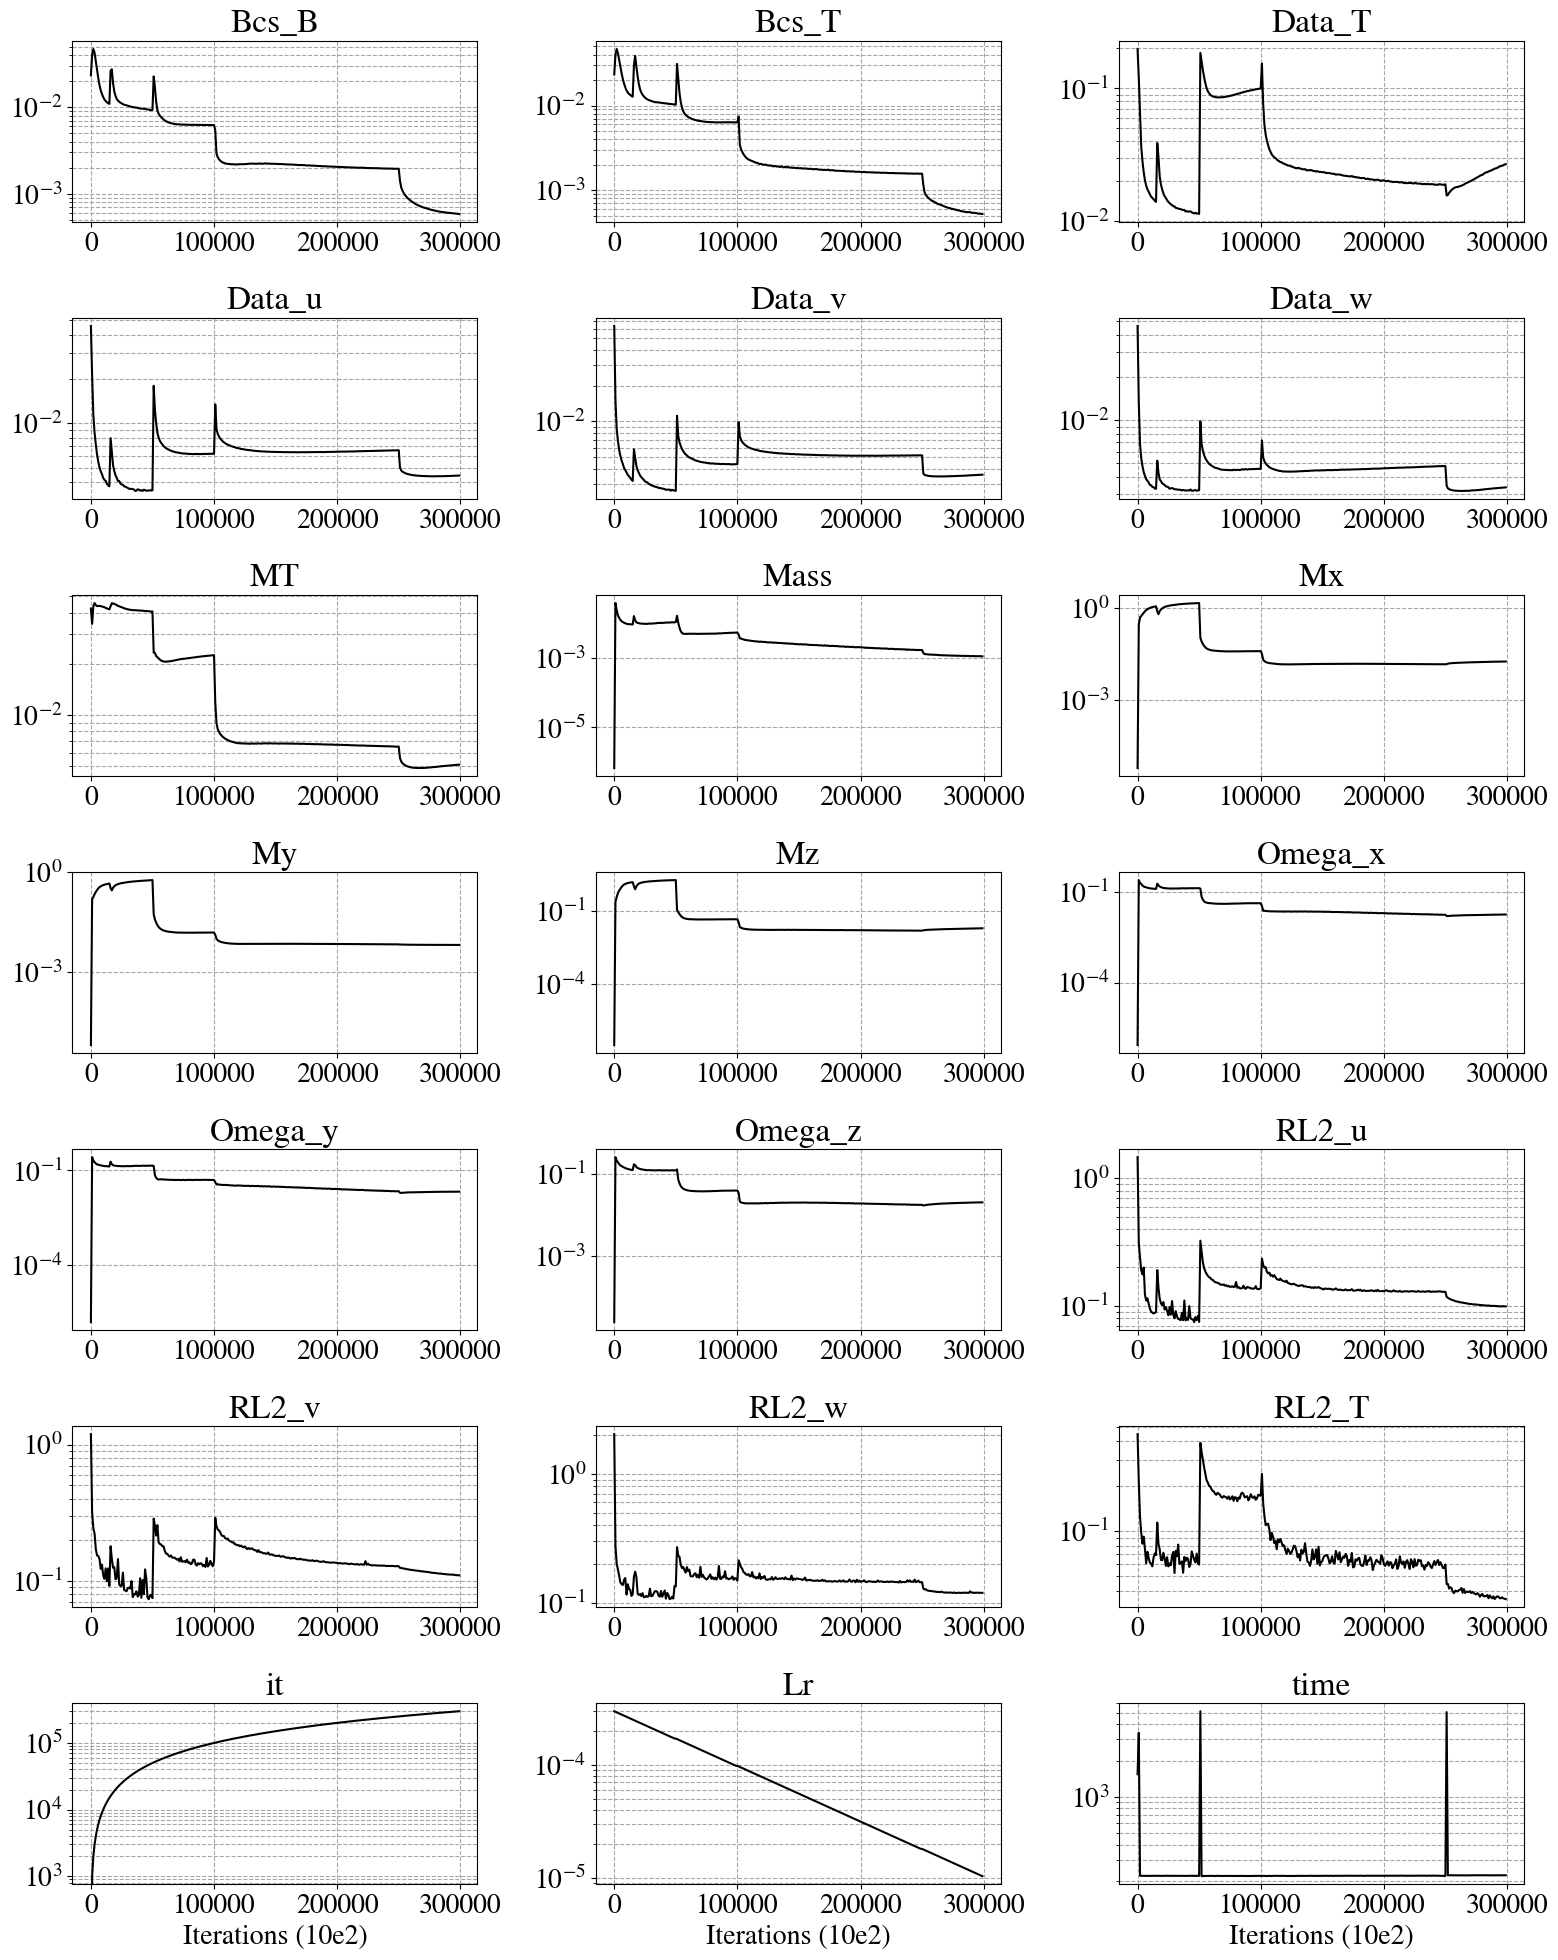

In [23]:
# Call the function
it_all,_=plot_losses_grid(log_loss[:-1],fig_h=16,fig_v=20)
plt.savefig(result_path + f'Losses.png')
plt.show()

In [24]:
def get_predictions(params):
    alpha,beta,params_NN=params
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    Omega=lambda x: jnp.sqrt(a(x)**2+b(x)**2+c(x)**2)
    return u, v,w, Omega , T   
u_model=get_predictions

In [25]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


plot


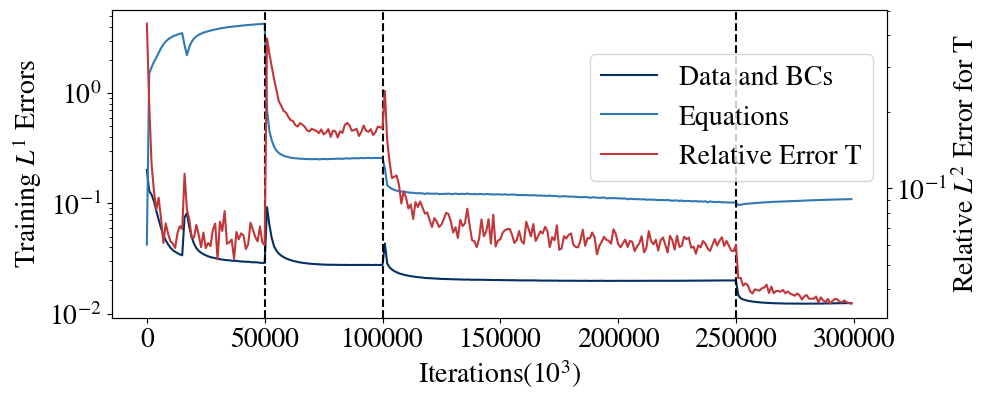

In [26]:
mpl.rcParams['font.size'] = 20
# Define the keys for the different error terms
Data_keys=['Data_u', 'Data_v','Data_w','Bcs_B','Bcs_T']
Eqn_keys=['Mx', 'My','Mz','Mass','MT','Omega_x','Omega_y','Omega_z']
Rl_error_keys=['RL2_T']

def plot_dual_axis(log_loss, Data_keys, Eqn_keys, Rl_error_keys, num_gsteps):
    iterations = it_all  # X-axis values assuming samples are taken every 1000 iterations

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Colors for different groups
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Plot left y-axis data for the sum of Data_keys
    data_sum = np.zeros(len(log_loss))
    for key in Data_keys:
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            data_sum += values
    ax1.plot(iterations, data_sum, label='Data and BCs', color=colors[0])

    # Plot left y-axis data for the sum of Eqn_keys
    eqn_sum = np.zeros(len(log_loss))
    for key in Eqn_keys:
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            eqn_sum += values
    ax1.plot(iterations, eqn_sum, label='Equations', color=colors[1])

    ax1.set_xlabel('Iterations($10^3$)')
    ax1.set_ylabel('Training $L^1$ Errors')
    ax1.set_yscale('log')

    # Create right y-axis
    ax2 = ax1.twinx()

    # Plot right y-axis data for Rl_error_keys
    for i, key in enumerate(Rl_error_keys):
        if key in log_loss[0]:
            values = np.array([entry[key] for entry in log_loss])
            ax2.plot(iterations, values, linestyle='-',label='Relative Error T' ,color=colors[-2])
    
    ax2.set_ylabel('Relative $L^2$ Error for T')
    ax2.set_yscale('log')


    ax1.axvline(x=activate_physics, color='k', linestyle='--')
    ax1.axvline(x=full_model, color='k', linestyle='--')
    ax1.axvline(x=Refine_it, color='k', linestyle='--')

    # Combine legends from both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', bbox_to_anchor=(1, 0.65))

    # Display the plot
    print('plot')

plot_dual_axis(log_loss[:-1], Data_keys, Eqn_keys, Rl_error_keys, num_gsteps)


In [31]:
u_fx, v_fx,w_fx, Omega_fx , T_fx     = u_model(params)
# Further computations for errors if any
u_pred  = vmap(u_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(dataset['Test'][:,0:layers_1[0]])[:,None]
velocity_magnitude = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)

u_real=dataset['Test'][:,4:5]
v_real=dataset['Test'][:,5:6]
w_real=dataset['Test'][:,6:7]
T_real=dataset['Test'][:,7:8]

RL2_u = relative_error2(u_pred, dataset['Test'][:,4:5])
RL2_v = relative_error2(v_pred, dataset['Test'][:,5:6])
RL2_w = relative_error2(w_pred, dataset['Test'][:,6:7])

RL2_T = relative_error2(T_pred, dataset['Test'][:,7:8])
print(f'Relative L2 errors for u:{RL2_u:.4e},v:{RL2_v:.4e},w:{RL2_w:.4e},T:{RL2_T:.4e}')
u_max, u_min = np.max(u_pred), np.min(u_pred)
v_max, v_min = np.max(v_pred), np.min(v_pred)
w_max, w_min = np.max(w_pred), np.min(w_pred)
T_max, T_min = np.max(T_pred), np.min(T_pred)
vmag_max, vmag_min= np.max(velocity_magnitude), np.min(velocity_magnitude)
Test_files={
    'txyz':dataset['Test'][:,0:layers_1[0]],
    'u':u_real,
    'v':v_real,
    'w':w_real,
    'T':T_real,
    'u_pred':u_pred,
    'v_pred':v_pred,
    'w_pred':w_pred,
    'T_pred':T_pred,
}
name_Test=result_path+'Test.mat'
scipy.io.savemat(name_Test,Test_files)


Relative L2 errors for u:9.8760e-02,v:1.0946e-01,w:1.2169e-01,T:3.5437e-02


In [32]:

# Compute Wasserstein distances for each variable
WD_u = wasserstein_distance(u_pred.ravel(), u_real.ravel())
WD_v = wasserstein_distance(v_pred.ravel(), v_real.ravel())
WD_w = wasserstein_distance(w_pred.ravel(), w_real.ravel())
WD_T = wasserstein_distance(T_pred.ravel(), T_real.ravel())

print(f'Wasserstein distances:')
print(f'  u: {WD_u:.4e}')
print(f'  v: {WD_v:.4e}')
print(f'  w: {WD_w:.4e}')
print(f'  T: {WD_T:.4e}')

Wasserstein distances:
  u: 7.0655e-04
  v: 4.2938e-04
  w: 6.7462e-04
  T: 4.9406e-03


## Convective Heat Transfer and Temperature

In [33]:
def J_convect(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )

    J = lambda x: (1/nu_2)*v(x)*(T(x)-T_mean)

    return J



In [34]:
T_mean=0.5
dataset['GT2']=X_sol
nu_2=jnp.sqrt(1/(Pr*Ra))
J_fx   = J_convect(params,Ra)
J_pred = vmap(J_fx, (0))(dataset['GT2'][:,:4])[:, None]
T_pred = vmap(T_fx, (0))(dataset['GT2'][:,:4])[:, None]-T_mean

J_test =(1/nu_2)*dataset['GT2'][:,5]*(dataset['GT2'][:,7]-T_mean)
T_test =(dataset['GT2'][:,7]-T_mean)

plot saved


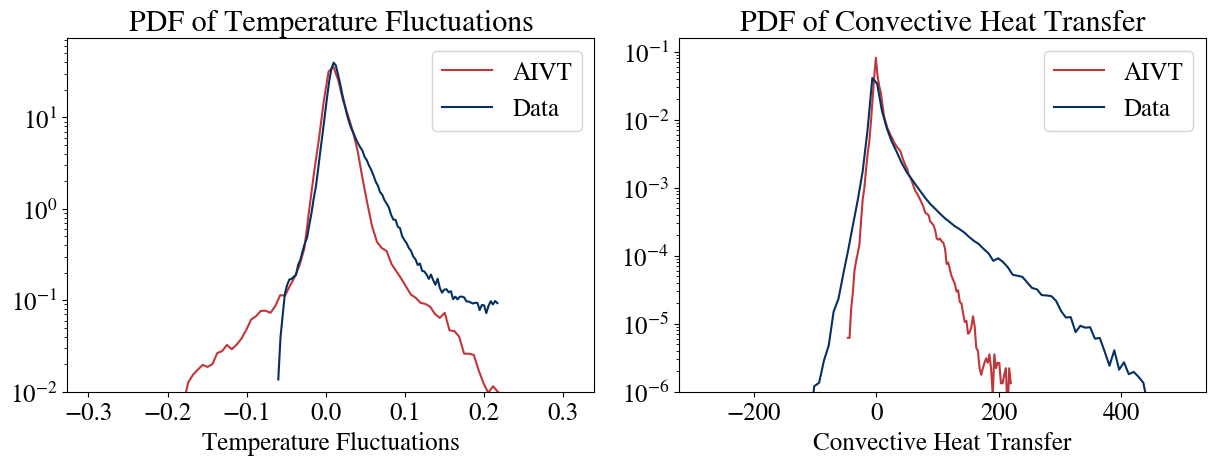

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 22

def get_pdf(u_hist, bins=30):
    hist, bins = np.histogram(u_hist, bins=bins, density=True)
    prob_density = hist
    return prob_density, bins

def get_colors_plot(cmap='RdBu', n_colors=2):
    cmap = plt.get_cmap(cmap)
    colors = [cmap(i) for i in np.linspace(0, 1, n_colors)]
    return colors

def plot_pdf_fields_with_error(datasets, field_names, colors, bins=100, figsize=(12.5, 5)):
    num_fields = len(datasets)
    fig, axs = plt.subplots(1, num_fields, figsize=figsize)  # 2 rows, 1 column

    for i, ((data_Ox, data_Oy), field_name) in enumerate(zip(datasets, field_names)):
        prob_density_Ox, bins_x = get_pdf(data_Ox, bins=bins)
        prob_density_Oy, bins_y = get_pdf(data_Oy, bins=bins)

        # Plotting data
        axs[i].set_xlabel(f'{field_name}')
        axs[i].plot(bins_y[:-1], prob_density_Oy, color=colors[-2], label=r'AIVT')
        axs[i].plot(bins_x[:-1], prob_density_Ox, color=colors[0], label=r'Data')

        axs[i].set_yscale('log')
        if i==0:
            axs[i].set_ylim(bottom=1e-2)
        elif i==1:
            axs[i].set_ylim(bottom=1e-6)
        axs[i].set_title(f'PDF of {field_name}')
        axs[i].legend(loc='upper right')

    plt.tight_layout()
    return fig

# Extracting and reshaping data
J_piv_hist = J_test.reshape(-1)
J_aiv_hist = J_pred.reshape(-1)

T_piv_hist = T_test.reshape(-1)
T_aiv_hist = T_pred.reshape(-1)

bins = 40

colors = get_colors_plot(cmap='RdBu_r', n_colors=8)
datasets = [(T_piv_hist, T_aiv_hist), (J_piv_hist, J_aiv_hist)]
field_names = ['Temperature Fluctuations', 'Convective Heat Transfer']

mpl.rcParams['font.size'] = 18

fig = plot_pdf_fields_with_error(datasets, field_names, colors)

plt.savefig('PDF_distributions.png')
print('plot saved')


# Plotting all Fields

In [36]:
def u_PINN_full(params):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    #vorticity:
    a=lambda x: w_y(x)-v_z(x)
    b=lambda x: u_z(x)-w_x(x)
    c=lambda x: v_x(x)-u_y(x)
    Omega=lambda x: jnp.sqrt(a(x)**2+b(x)**2+c(x)**2)
    return u, v,w,a,b,c, Omega , T   

# %%
def epislon_T(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents

    T_x = lambda x: derivative_fn(T, x, 1)
    T_y = lambda x: derivative_fn(T, x, 2)
    T_z = lambda x: derivative_fn(T, x, 3)

    e_T = lambda x: (1e3)*nu_2*(T_x(x)**2+T_y(x)**2+T_z(x)**2)
    return e_T


# %%
def epislon_k(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    """
    input = (x, y)
    output = (u, v, p,T)
    sqrt_Pr_Ra
    sqrt_RaPr
    """
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents

    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)    

    T_x = lambda x: derivative_fn(T, x, 1)
    T_y = lambda x: derivative_fn(T, x, 2)
    T_z = lambda x: derivative_fn(T, x, 3)

    e_k = lambda x: 1000*(nu_1/2*((2*u_x(x))**2+
                             (2*v_y(x))**2+
                             (2*w_z(x))**2+
                          2 *(u_y(x)+v_x(x))**2+
                          2 *(u_z(x)+w_x(x))**2+
                          2 *(v_z(x)+w_y(x))**2                         
                          ))

    return e_k




In [37]:
# Find bounds

# %%
u_fx, v_fx,w_fx,a_fx,b_fx,c_fx, Omega_fx , T_fx   = u_PINN_full(params)
e_k_fx   = epislon_k(params,Ra)
e_T_fx   = epislon_T(params,Ra)

# Further computations for errors if any
u_pred  = vmap(u_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
v_pred  = vmap(v_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
w_pred  = vmap(w_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
O_pred  = vmap(Omega_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
T_pred  = vmap(T_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
Omega_x=  vmap(a_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
Omega_y=  vmap(b_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
Omega_z=  vmap(c_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
e_k=  vmap(e_k_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]
e_T=  vmap(e_T_fx, (0))(dataset['Data_T'][:,0:layers_1[0]])[:,None]

velocity_magnitude = np.sqrt(u_pred**2 + v_pred**2 + w_pred**2)


u_max, u_min = np.max(u_pred), np.min(u_pred)
v_max, v_min = np.max(v_pred), np.min(v_pred)
w_max, w_min = np.max(w_pred), np.min(w_pred)
O_max, O_min = np.max(O_pred), np.min(O_pred)
T_max, T_min = np.max(T_pred), np.min(T_pred)

Omega_x_max, Omega_x_min = np.max(Omega_x), np.min(Omega_x)
Omega_y_max, Omega_y_min = np.max(Omega_y), np.min(Omega_y)
Omega_z_max, Omega_z_min = np.max(Omega_z), np.min(Omega_z)

e_k_max, e_k_min = np.max(e_k), np.min(e_k)
e_T_max, e_T_min = np.max(e_T), np.min(e_T)

vmag_max, vmag_min= np.max(velocity_magnitude), np.min(velocity_magnitude)

  0%|          | 0/1 [00:00<?, ?it/s]

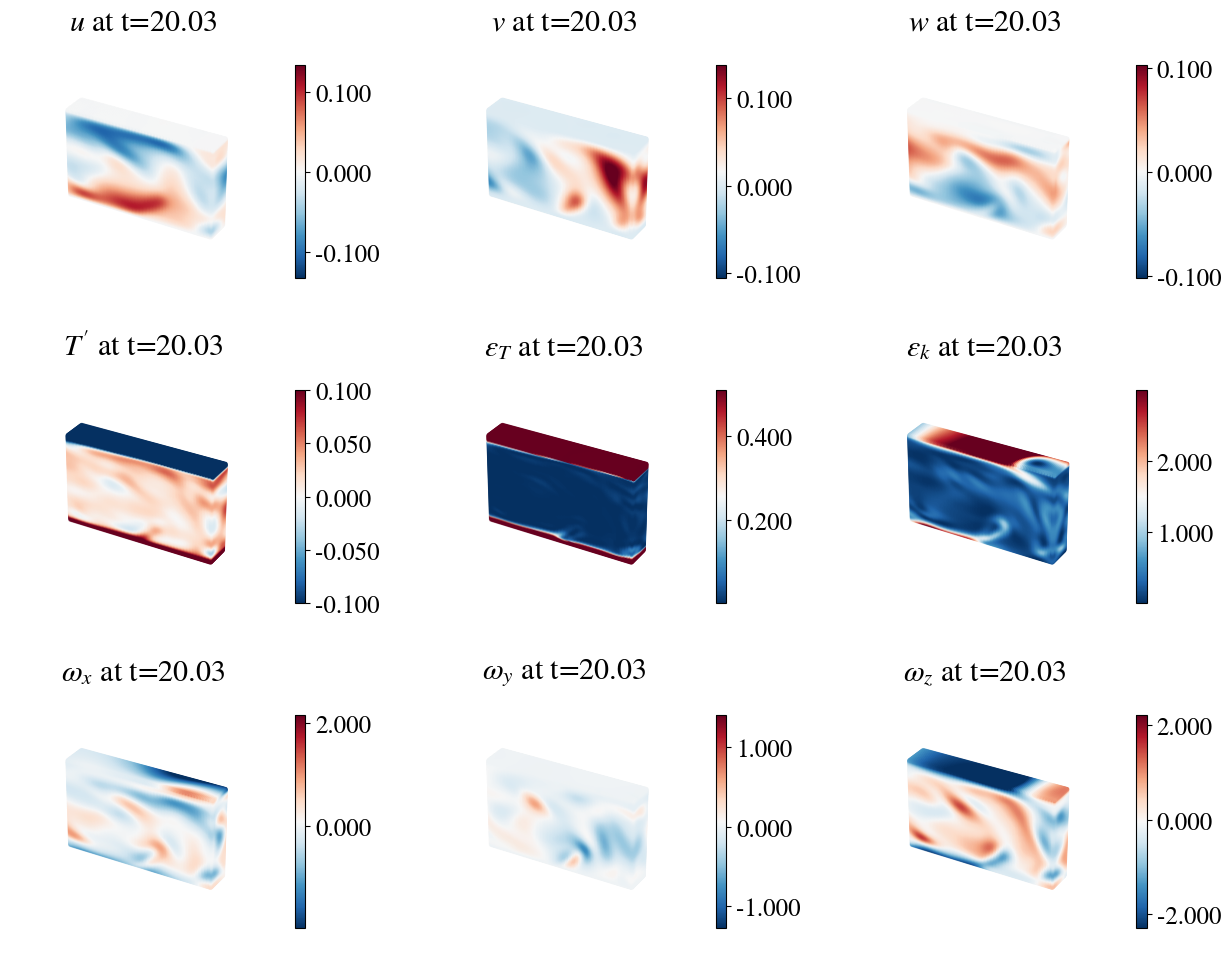

100%|██████████| 1/1 [01:16<00:00, 76.79s/it]


In [45]:
all_times=np.sort(np.unique(X_train[:,0]))
# Find midpoints in spatial dimensions
mid_x = np.max(X_eval[:, 0])
mid_y = np.max(X_eval[:, 1])
mid_z = np.min(X_eval[:, 2])

# Find indices near midpoints in spatial dimensions
near_mid_x = np.where(np.abs(X_eval[:, 0] - mid_x) < tolerance)[0]
near_mid_y = np.where(np.abs(X_eval[:, 1] - mid_y) < tolerance)[0]
near_mid_z = np.where(np.abs(X_eval[:, 2] - mid_z) < tolerance)[0]

# Get the intersection of indices
common_indices = np.union1d(near_mid_x, np.union1d(near_mid_y, near_mid_z))

# Extract the relevant points
X_midpoints_not = X_eval[common_indices]
all_times=np.sort(np.unique(dataset["GT"][:,0]))
start=len(all_times)//2
end=start+1
#end=len(all_times)
u_fx, v_fx,w_fx,a_fx,b_fx,c_fx, Omega_fx , T_fx   = u_PINN_full(params)
e_T_fx   = epislon_T(params,Ra)
e_k_fx   = epislon_k(params,Ra)

for start in tqdm.tqdm(range(start,end)):
    target_time=all_times[start]
    X_midpoints = np.hstack((X_midpoints_not[:, 0:1] *0+ target_time, X_midpoints_not))
    # Get model predictions
    u_pred_mid = vmap(u_fx, (0))(X_midpoints)[:, None]
    v_pred_mid = vmap(v_fx, (0))(X_midpoints)[:, None]
    w_pred_mid = vmap(w_fx, (0))(X_midpoints)[:, None]
    O_pred_mid = vmap(Omega_fx, (0))(X_midpoints)[:, None]
    T_pred_mid = vmap(T_fx, (0))(X_midpoints)[:, None]-T_mean
    e_T_pred_mid = vmap(e_T_fx, (0))(X_midpoints)[:, None]
    e_k_pred_mid = vmap(e_k_fx, (0))(X_midpoints)[:, None]

    Ox_pred_mid = vmap(a_fx, (0))(X_midpoints)[:, None]
    Oy_pred_mid = vmap(b_fx, (0))(X_midpoints)[:, None]
    Oz_pred_mid = vmap(c_fx, (0))(X_midpoints)[:, None]

    #velocity_magnitude = np.sqrt(u_pred_mid**2 + v_pred_mid**2 + w_pred_mid**2)

    # Create a 3x2 subplot grid
    fig = plt.figure(figsize=(13, 10))

    variables = [u_pred_mid, v_pred_mid, w_pred_mid, 
                T_pred_mid, e_T_pred_mid, e_k_pred_mid,
                Ox_pred_mid,Oy_pred_mid,Oz_pred_mid]
    titles = ['$u$', '$v$', '$w$', 
              "$T'$", r'$\varepsilon_T$', r'$\varepsilon_k$',
              r"$\omega_x$",r"$\omega_y$",r"$\omega_z$"]
    # Calculate the max range for true dimensions
    max_range = np.array([X_midpoints[:, 1].max() - X_midpoints[:, 1].min(), 
                        X_midpoints[:, 2].max() - X_midpoints[:, 2].min(), 
                        X_midpoints[:, 3].max() - X_midpoints[:, 3].min()]).max() / 2.0

    mid_x = X_midpoints[:, 1].mean()
    mid_z = X_midpoints[:, 3].mean()
    mid_y = X_midpoints[:, 2].mean()
    min_max_values = [(u_min, u_max), (v_min, v_max), (w_min, w_max),
                     (-0.1, 0.1), (e_T_min, e_T_max), (e_k_min, e_k_max),
                    (Omega_x_min, Omega_x_max ),(Omega_y_min, Omega_y_max ),(Omega_z_min, Omega_z_max )]

    for i, (variable, title, (vmin, vmax)) in enumerate(zip(variables, titles, min_max_values)):
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        if title=='e_T':
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='RdBu_r',s=5)# vmin=vmin, vmax=vmax, s=5)
        else:
            scatter = ax.scatter(X_midpoints[:, 1], X_midpoints[:, 3], X_midpoints[:, 2], c=variable.ravel(), cmap='RdBu_r', vmin=vmin, vmax=vmax, s=5)
           
        ax.set_title(f'{title} at t={target_time:.2f}')

        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
        cbar.formatter = FormatStrFormatter('%.3f')
        cbar.update_ticks()

        # Set the same limits for all three axes based on the max range
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_z - max_range, mid_z + max_range)
        ax.set_zlim(mid_y - max_range, mid_y + max_range)

        plt.axis('off')

    plt.tight_layout()
    plt.savefig(All_path + f"at_t={(target_time/len(all_times)):.5f}.png")
    if start + 1 < end:
        plt.close()
    else:
        plt.show()


# Boundary Layer

In [39]:
delta_t=1/44
d_y=(5*delta_t)/500
print(d_y)
# Define the arrays
y_plot = np.arange((1-5*delta_t), 1+d_y, d_y)
x_plot = np.arange(lb[1], ub[1]+d_y, d_y*20)

# Create the meshgrid
X, Y = np.meshgrid(x_plot, y_plot)
u_fx, v_fx,w_fx,a_fx,b_fx,c_fx, Omega_fx , T_fx   = u_PINN_full(params)

t_frame=29.97586309
#Flatten 
X_bd_layer=np.hstack((X.flatten()[:,None]*0+t_frame,X.flatten()[:,None],Y.flatten()[:,None],X.flatten()[:,None]*0))
print(X_bd_layer.min(0))
print(X_bd_layer.max(0))
print(X.flatten().shape)

T_bl_pred = vmap(T_fx, (0))(X_bd_layer)[:, None]
U_bl_pred = vmap(u_fx, (0))(X_bd_layer)[:, None]
V_bl_pred = vmap(v_fx, (0))(X_bd_layer)[:, None]
W_bl_pred = vmap(v_fx, (0))(X_bd_layer)[:, None]


T_Bl_mesh=T_bl_pred.reshape(X.shape)
U_Bl_mesh=U_bl_pred.reshape(X.shape)
V_Bl_mesh=V_bl_pred.reshape(X.shape)
W_Bl_mesh=W_bl_pred.reshape(X.shape)
V_mag_mesh=np.sqrt(U_Bl_mesh**2+V_Bl_mesh**2+W_Bl_mesh**2)

0.0002272727272727273
[29.97586309 -0.61530678  0.88636364  0.        ]
[29.97586309  0.63469322  1.00022727  0.        ]
(138552,)


In [40]:
# Define the arrays
y_plot = np.arange(0, 5*delta_t+d_y, d_y)
x_plot = np.arange(lb[1], ub[1], d_y*20)

# Create the meshgrid
X_L, Y_L = np.meshgrid(x_plot, y_plot)
#Flatten 
X_bd_layer_L=np.hstack((X_L.flatten()[:,None]*0+t_frame,X_L.flatten()[:,None],Y_L.flatten()[:,None],X_L.flatten()[:,None]*0))
print(X_bd_layer_L.min(0))
print(X_bd_layer_L.max(0))
print(X_L.flatten().shape)

T_bl_pred = vmap(T_fx, (0))(X_bd_layer_L)[:, None]
U_bl_pred = vmap(u_fx, (0))(X_bd_layer_L)[:, None]
V_bl_pred = vmap(v_fx, (0))(X_bd_layer_L)[:, None]
W_bl_pred = vmap(v_fx, (0))(X_bd_layer_L)[:, None]


T_Bl_mesh_L=T_bl_pred.reshape(X_L.shape)
U_Bl_mesh_L=U_bl_pred.reshape(X_L.shape)
V_Bl_mesh_L=V_bl_pred.reshape(X_L.shape)
W_Bl_mesh_L=W_bl_pred.reshape(X_L.shape)
V_mag_mesh_L=np.sqrt(U_Bl_mesh_L**2+V_Bl_mesh_L**2+W_Bl_mesh_L**2)


[29.97586309 -0.61530678  0.          0.        ]
[29.97586309  0.63469322  0.11363636  0.        ]
(138276,)


/tmp/ipykernel_3801348/1731117313.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])


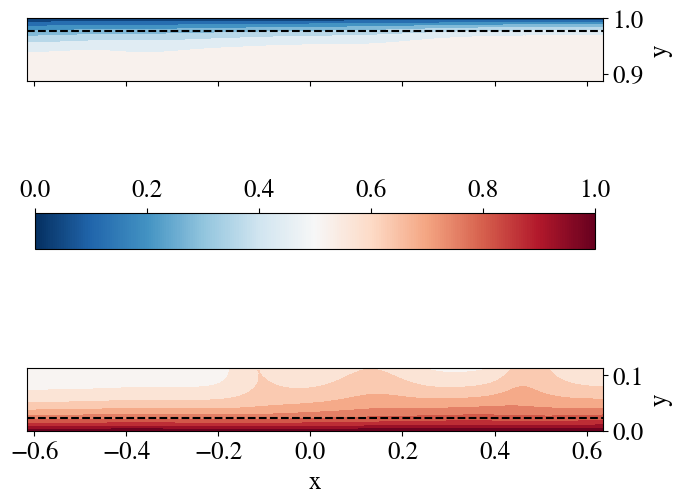

In [41]:
# Set font size
mpl.rcParams['font.size'] = 18

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

# Define normalization for consistent color scaling
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Plot first contour plot
cp1 = ax1.contourf(X, Y, T_Bl_mesh, levels=8, cmap='RdBu_r', norm=norm)
ax1.axhline(y=(1-delta_t), color='black', linestyle='--')
ax1.set_aspect(1.2)
ax1.set_ylabel('y')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_xticklabels([])

# Plot second contour plot
cp2 = ax2.contourf(X_L, Y_L, T_Bl_mesh_L, levels=8, cmap='RdBu_r', norm=norm)
ax2.axhline(y=delta_t, color='black', linestyle='--')
ax2.set_aspect(1.2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
# Create a single colorbar for both plots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.05, 0.43, 0.8, 0.03])

# Create a ScalarMappable with the same norm and colormap as the contour plots
sm = mpl.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm.set_array([])

# Add the colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# QR Plots

(817686, 3, 3)


100%|██████████| 817686/817686 [00:28<00:00, 29180.20it/s]


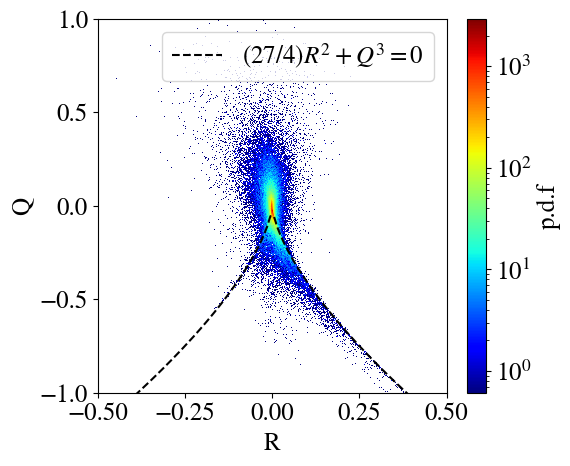

In [46]:

def QR(params,Ra):
    alpha,beta,params_NN=params
    nu_1=jnp.sqrt(Pr/Ra)
    nu_2=jnp.sqrt(1/(Pr*Ra))
    # Neural Network
    phi_T = lambda x: (x[2])*(Y_max-x[2])/0.25#normalize it
    g_T =lambda x: - x[2]+1.0# base solution
    fn={
        "uvwT" :lambda x: pinn_fn(params_NN["uvwT"], x, M1, M2,activation_fn,norm_fn),
    }

    u, v,w,T = (
                 lambda x: u_scale*fn["uvwT"](x)[0], 
                 lambda x: v_scale*fn["uvwT"](x)[1], 
                 lambda x: w_scale*fn["uvwT"](x)[2], 
                 lambda x: g_T(x)+T_scale*phi_T(x)*fn["uvwT"](x)[3],
                 )
   # derivatives
    def derivative_fn(f, x, idx):
        """Computes df/dx[idx] using forward mode AD."""
        perturbation = jnp.zeros_like(x)
        perturbation = perturbation.at[idx].set(1.0)
        primals, tangents = jvp(f, (x,), (perturbation,))
        return tangents

    u_t = lambda x: derivative_fn(u, x, 0)
    u_x = lambda x: derivative_fn(u, x, 1)
    u_y = lambda x: derivative_fn(u, x, 2)
    u_z = lambda x: derivative_fn(u, x, 3)

    v_t = lambda x: derivative_fn(v, x, 0)
    v_x = lambda x: derivative_fn(v, x, 1)
    v_y = lambda x: derivative_fn(v, x, 2)
    v_z = lambda x: derivative_fn(v, x, 3)

    w_t = lambda x: derivative_fn(w, x, 0)
    w_x = lambda x: derivative_fn(w, x, 1)
    w_y = lambda x: derivative_fn(w, x, 2)
    w_z = lambda x: derivative_fn(w, x, 3)
    # equations
    A11 = lambda x: u_x(x)
    A12 = lambda x: u_y(x)
    A13 = lambda x: u_z(x)
    A21 = lambda x: v_x(x)
    A22 = lambda x: v_y(x)
    A23 = lambda x: v_z(x)
    A31 = lambda x: w_x(x)
    A32 = lambda x: w_y(x)
    A33 = lambda x: w_z(x)


    return A11,A12,A13,A21,A22,A23,A31,A32,A33
A11_fx,A12_fx,A13_fx,A21_fx,A22_fx,A23_fx,A31_fx,A32_fx,A33_fx  = QR(params,Ra)
# Further computations for errors if any
A11  = vmap(A11_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A12  = vmap(A12_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A13  = vmap(A13_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]

A21  = vmap(A21_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A22  = vmap(A22_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A23  = vmap(A23_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]

A31  = vmap(A31_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A32  = vmap(A32_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
A33  = vmap(A33_fx, (0))(dataset['Res'][:,0:layers_1[0]])[:,None]
depth=len(A11)
Aij=np.zeros((depth,3,3))
print(Aij.shape)
#Filling the matrix
Aij[:,0,0]=A11.flatten()
Aij[:,0,1]=A12.flatten()
Aij[:,0,2]=A13.flatten()
Aij[:,1,0]=A21.flatten()
Aij[:,1,1]=A22.flatten()
Aij[:,1,2]=A23.flatten()
Aij[:,2,0]=A31.flatten()
Aij[:,2,1]=A32.flatten()
Aij[:,2,2]=A33.flatten()
Q=[]

for k in tqdm.tqdm(range(len(Aij))):
    Q.append((-1/2)*np.sum(Aij[k]*Aij[k].T))
R=[]
for k in tqdm.tqdm(range(len(Aij))):
    A=Aij[k]
    R_point=0
    for i in range(3):
        for m in range(3):
            for n in range(3):
               R_point=R_point+A[i][m]*A[m][n]*A[n][i]
    R.append((-1/3)*R_point)

# Generate R values
R_values = np.linspace(-2, 2, 400)
# Calculate Q values from the curve equation
Q_values = -((27/4) * R_values**2)**(1/3)

mpl.rcParams['font.size'] = 18
pred_Q_R={
    'Q':np.array(Q),
    'R':np.array(R),
    'Q_line':Q_values,
    'R_line':R_values,
}

 
fig,ax=plt.subplots(1,1,figsize=(6,5))

im=ax.hist2d(pred_Q_R['R'].squeeze(),pred_Q_R['Q'].squeeze(),density=True,bins=1000,range=[[-0.5,0.5],[-1,1]],norm=col.LogNorm(),cmap='jet')

ax.plot(pred_Q_R['R_line'].squeeze(),pred_Q_R['Q_line'].squeeze(),'k--',label=r'$(27/4)R^2+Q^3=0$')

ax.set_xlabel('R')
plt.legend()
ax.set_ylabel('Q')

cbar=fig.colorbar(im[3],ax=ax,fraction=0.1,label='p.d.f',orientation="vertical")

plt.tight_layout()
plt.savefig('QR.png')
 

# Dissipation Plots

In [47]:
lb, ub = np.min(X_star_f, axis=0), np.max(X_star_f, axis=0)
x_min, y_min = lb[0], lb[1]
x_max, y_max = ub[0], ub[1]
print(lb)
print(ub)
print(X_star_f.shape,u_star_f.shape)

dx=(ub[1]-lb[1])/120
print(dx)

[10.01546484 -0.61530678  0.01921525 -0.10071864]
[29.97586309  0.63559492  0.99108983  0.10093542]
(840816, 4) (840816, 4)
0.010424180790960453


In [48]:
# %%
# Given ranges for x, y, and z
t_list = np.linspace(lb[0], ub[0], 200).flatten()[:, None]
x_list = np.arange(lb[1], ub[1], dx).flatten()[:, None]
y_list = np.arange(0, 1, dx).flatten()[:, None]
z_list = np.arange(lb[3], ub[3],dx).flatten()[:, None]

# Create 3D mesh
X_mesh, Y_mesh, Z_mesh = np.meshgrid(x_list.flatten(), y_list.flatten(), z_list.flatten(), indexing='ij')

# Printing shapes for verification
print(f"X_mesh shape: {X_mesh.shape}")
print(f"Y_mesh shape: {Y_mesh.shape}")
print(f"Z_mesh shape: {Z_mesh.shape}")
X_eval=np.hstack((X_mesh.flatten()[:, None],
                  Y_mesh.flatten()[:, None],
                  Z_mesh.flatten()[:, None],))

print(f"X_eval shape: {X_eval.shape}")

all_frames=[]
u_fx, v_fx,w_fx, Omega_fx , T_fx     = u_model(params)
e_T_fx   = epislon_T(params,Ra)
e_k_fx   = epislon_k(params,Ra)
for time_frame in tqdm.tqdm(t_list):
    X_frame=np.hstack((X_eval[:,0:1]*0+time_frame,X_eval))
    # Further computations for errors if any
    u_pred  = vmap(u_fx, (0))(X_frame)[:,None]
    v_pred  = vmap(v_fx, (0))(X_frame)[:,None]
    w_pred  = vmap(w_fx, (0))(X_frame)[:,None]
    O_pred  = vmap(Omega_fx, (0))(X_frame)[:,None]
    T_pred  = vmap(T_fx, (0))(X_frame)[:,None]
    e_T_pred  = vmap(e_T_fx, (0))(X_frame)[:,None]/1000
    e_k_pred  = vmap(e_k_fx, (0))(X_frame)[:,None]/1000
    X_frame=np.hstack((X_frame,u_pred,v_pred,w_pred,O_pred,T_pred,e_T_pred,e_k_pred))
    all_frames.append(X_frame)
all_frames=np.array(all_frames)
print(all_frames.shape)
save_file=result_path+f'All_results_{train_ratio}.mat'
save_data={
    'Data':all_frames,
    'names':'txyzuvwOmegaTeTek'
}
scipy.io.savemat(save_file,save_data)

X_mesh shape: (121, 96, 20)
Y_mesh shape: (121, 96, 20)
Z_mesh shape: (121, 96, 20)
X_eval shape: (232320, 3)


100%|██████████| 200/200 [13:22<00:00,  4.01s/it]


(200, 232320, 11)


In [49]:
PINN_grided_data=scipy.io.loadmat(save_file)
interp_txyzuvwpTeTek=PINN_grided_data['Data']
columns_interp=['t','x','y','z','u','v','w','p','T','eT','eK']
interp_grided_data_pd=pd.DataFrame(data=interp_txyzuvwpTeTek.reshape(-1,11),columns=columns_interp)

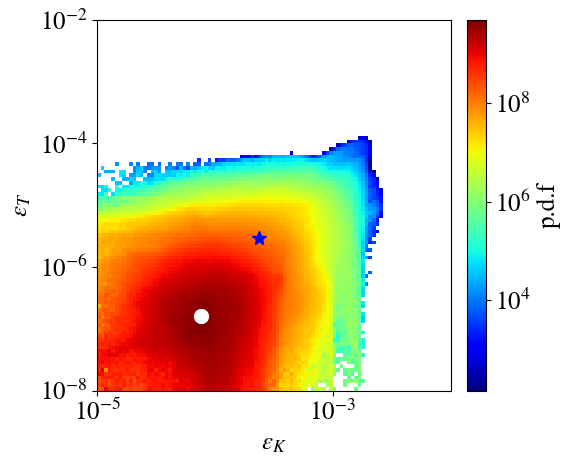

: 

In [ ]:
mpl.rcParams['font.size'] = 18

# Filter the data for the selected range
interp_grided_data_pd_bulk = interp_grided_data_pd[(interp_grided_data_pd['y'] >= 0.4) & (interp_grided_data_pd['y'] < 0.6)]

# Create the figure and axis for a single plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for interpolated data
im = ax.hist2d(interp_grided_data_pd_bulk['eK'].values, interp_grided_data_pd_bulk['eT'].values, density=True,
               bins=[np.logspace(np.log10(1e-5), np.log10(1e-2), 100),
                     np.logspace(np.log10(1e-8), np.log10(1e-2), 100)], 
               norm=col.LogNorm(), cmap='jet')

# Find the location of max probability density
dissipation_max_prob = np.unravel_index(np.argmax(im[0]), (99, 99))
eK_mean = interp_grided_data_pd_bulk['eK'].values.mean()
eT_mean = interp_grided_data_pd_bulk['eT'].values.mean()

# Plot markers for max probability density and mean values
ax.plot(im[1][dissipation_max_prob[0]], im[2][dissipation_max_prob[1]], 'wo', markersize=10)
ax.plot(eK_mean, eT_mean, 'b*', markersize=10)

# Set labels and log scales
ax.set_xlabel('$\epsilon_K$')
ax.set_ylabel('$\epsilon_T$')
ax.set_xscale('log')
ax.set_yscale('log')

# Add colorbar
fig.colorbar(im[3], ax=ax, fraction=0.1, pad=0.04, label='p.d.f', orientation="vertical")

plt.tight_layout()
plt.savefig('joint_pdf_interpolated.png')
plt.show()
